Recreate Figures and Table Values for A. N. Poletti Paper

In [40]:
## Import Libraries ##

# Math and Science Libraries
import numpy as np
import scipy.optimize as sci
from scipy import stats
from scipy import signal
from scipy.signal import savgol_filter
import statsmodels.formula.api as smf

# Data Array Libraries
import xarray as xr
import pandas as pd

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.util as cutil

# Misc
import warnings

print('Done')

Done


# Imported Data, Constant Values, Parameters, Etc.

In [41]:
## Parameters and Constant Values ##

# Experiments
experiment2 = 'abrupt-2xCO2'
experiment4 = 'abrupt-4xCO2'

experiment_list = [experiment2, experiment4]

# Models
model_list1 = ['CanESM5', 'CESM2', 'MIROC6'] # models with rtmt

model_list2 = ['CNRM-CM6-1', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MRI-ESM2-0'] # models without rtmt

model_list3 = ['CanESM5', 'MIROC6', 'CNRM-CM6-1', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR'] # 6 model ensemble

model_list  = model_list1 + model_list2 # total model list

# Variables
variable1 = 'rtmt'
variable2 = 'tas'
variable5 = 'rsdt'
variable3 = 'rsut'
variable4 = 'rlut'

variable_list = [variable1, variable2, variable3, variable4, variable5]

# Parameters
normalize = 0.476 # scaling factor for abrupt-4xCO2 from IPCC AR6

time = np.arange(0, 150) # time array, years 1 to 150

map_proj = ccrs.Robinson(central_longitude=0) # Robinson map projection centered in the Pacific

normalize_model = {'CanESM5': 0.473,
                   'CESM2': 0.611,
                   'MIROC6': 0.474, 
                   'CNRM-CM6-1': 0.459,
                   'GISS-E2-1-G': 0.484, 
                   'GISS-E2-1-H': 0.516, 
                   'IPSL-CM6A-LR': 0.523, # ratio of ERF (1-150) abrupt-2xCO2 / ERF abrupt-4xCO2      
                   'MRI-ESM2-0': 0.520}   # first twenty year Gregory regression below
                                        

In [42]:
## PiControl Last 100 Year Average Value ##

data_pi = {}
data_pi['tas'] = {}
data_pi['rtmt'] = {}

# PiControl tas
data_pi['tas']['CanESM5']=286.48
data_pi['tas']['CESM2']=287.24
data_pi['tas']['MIROC6']=288.42
data_pi['tas']['CNRM-CM6-1']=286.11
data_pi['tas']['GISS-E2-1-G']=286.96
data_pi['tas']['GISS-E2-1-H']=287.29
data_pi['tas']['IPSL-CM6A-LR']=285.76
data_pi['tas']['MRI-ESM2-0']=287.02

# PiControl rtmt
data_pi['rtmt']['CanESM5']=0.1502733919579207
data_pi['rtmt']['CESM2']=0.0627849664
data_pi['rtmt']['MIROC6']=1.123561605
data_pi['rtmt']['CNRM-CM6-1']=1.4748364207491989
data_pi['rtmt']['GISS-E2-1-G']=0.08883144773
data_pi['rtmt']['GISS-E2-1-H']=0.02130745715
data_pi['rtmt']['IPSL-CM6A-LR']=0.704934
data_pi['rtmt']['MRI-ESM2-0']=0.9168377706666888

In [43]:
## Import Data ##

# Load annual, global mean tas, rtmt, rsut, rlut, rsdt data
# Load hemisphere averages for tas
## Calculated from monthly mean data downloded from the CMIP6 Data Repository https://esgf-node.llnl.gov/search/cmip6/
data = {} 

for exp in experiment_list:
    data[exp] = {}

    for model in model_list:
        data[exp][model] = {}
        
        for var in variable_list:
            
            try:
                data[exp][model][var] = np.loadtxt('%s/%s_%s_%s_gm.csv' % (var, model, exp, var), delimiter=",", dtype=float)
                
            except FileNotFoundError: # data is not available for this model
                print('No %s %s Data Found For %s' % (var, exp, model))
                continue
                
            try:
                data[exp][model][var + '-sh'] = np.loadtxt('%s/%s_%s_%s_sh.csv' % (var, model, exp, var), delimiter=",", dtype=float)
                data[exp][model][var + '-nh'] = np.loadtxt('%s/%s_%s_%s_nh.csv' % (var, model, exp, var), delimiter=",", dtype=float)
                print('Hemisphere temperature data found for %s!' % model)
                
            except FileNotFoundError: # hemisphere data only for temperature
                continue
                
# Load heat capacity data
## Calculate heat capacity using /heat_capacity/calculate_heat_capacity.ipynb
heat_capacity_2x = pd.read_csv("heat_capacity/heat_capacity_data_2x.csv")
heat_capacity_4x = pd.read_csv("heat_capacity/heat_capacity_data_4x.csv")

# Load AMOC data
## Calculate AMOC strength using /AMOC/AMOC_index.ipynb; 
## requires CMIP6 streamfunction (msftmz or msftyz) data from https://esgf-node.llnl.gov/search/cmip6/
AMOC_decline_2x = pd.read_csv('AMOC/AMOC_decline_2x.csv')
AMOC_decline_4x = pd.read_csv('AMOC/AMOC_decline_4x.csv')

AMOC_strength_2x = pd.read_csv('AMOC/AMOC_strength_2x.csv')
AMOC_strength_4x = pd.read_csv('AMOC/AMOC_strength_4x.csv')
AMOC_pi          = pd.read_csv('AMOC/AMOC_strength_pi.csv')

model_list_amoc = np.array(AMOC_strength_2x.columns)
time_amoc = np.array(AMOC_strength_2x.index)

# Load global depth of heat storage data
## Calculate heat storage to depth of heat storage using /heat_storage_global/Heat_Storage_to_Depth.ipynb
heat_storage = {}
location = ['global', 'north', 'south']
percents = ['30', '40', '45', '50', '55', '60', '70', '80']

for exp in experiment_list:
    heat_storage[exp] = {}

    for model in model_list:
        heat_storage[exp][model] = {}
        
        for loc in location:
            heat_storage[exp][model][loc] = {}
            
            for per in percents:
            
                try:
                     heat_storage[exp][model][loc][per] = np.loadtxt('heat_storage_global/depth_%s_%s_%s_%s.csv' % (per, model, exp, loc), delimiter=",", dtype=float)
                
                except FileNotFoundError: # data is not available for this model
                    print('No Global Heat Storage %s Data Found for %s' % (exp, model))
                    continue
                    
# Load zonal depth of heat storage data
## Convert heat storage to depth of heat storage using /heat_storage_zonal/Heat_Storage_to_Depth.ipynb
## Calculate heat storage using thetao data downloaded from https://esgf-node.llnl.gov/search/cmip6/
zonal_storage = {}
lats = {}
percents = ['50', '55', '80']

for exp in experiment_list:
    zonal_storage[exp] = {}

    for model in model_list:
        zonal_storage[exp][model] = {}
        
        try:
            lats[model] = np.loadtxt('heat_storage_zonal/%s_latitude.csv' % model, delimiter=",", dtype=float)
            
        except FileNotFoundError: # data is not available for this model
                continue
        
        for per in percents:
            
            try:
                zonal_storage[exp][model][per] = np.loadtxt('heat_storage_zonal/depth_%s_%s_%s.csv' % (per, model, exp), delimiter=",", dtype=float)
                
            except FileNotFoundError: # data is not available for this model
                print('No Zonal Heat Storage %s Data Found for %s' % (exp, model))
                continue

# Load APRP data

## years 1-150
aprp_map_2x = xr.open_dataset('/home/disk/p/apolet/SummerCode/paper_data/APRP/cmip6_analysis_out_2x/abrupt-2xCO2_APRP_frombase_historical_1851-1870.nc')
aprp_map_4x = xr.open_dataset('/home/disk/p/apolet/SummerCode/paper_data/APRP/cmip6_analysis_out_4x/abrupt-4xCO2_APRP_frombase_historical_1851-1870.nc')

## slow and fast periods
aprp_map_2x_periods = xr.open_dataset('APRP/abrupt-2xCO2_APRP.nc')
aprp_map_4x_periods = xr.open_dataset('APRP/abrupt-4xCO2_APRP.nc')

# Load Tas anomaly lat-lon data
## Mean over entire 1-150 year runtime
temperature = {}

for exp in experiment_list:
    temperature[exp] = {}

    for model in model_list:
        try:
             temperature[exp][model] = pd.read_csv('tas/%s_tas_field_%s.csv' % (model, exp), delimiter=",", dtype=float)
                
        except FileNotFoundError: # data is not available for this model
            print('No %s %s Data Found For %s' % (var, exp, model))
            continue

Hemisphere temperature data found for CanESM5!
No rsut abrupt-2xCO2 Data Found For CanESM5
No rlut abrupt-2xCO2 Data Found For CanESM5
No rsdt abrupt-2xCO2 Data Found For CanESM5
Hemisphere temperature data found for CESM2!
No rsut abrupt-2xCO2 Data Found For CESM2
No rlut abrupt-2xCO2 Data Found For CESM2
No rsdt abrupt-2xCO2 Data Found For CESM2
Hemisphere temperature data found for MIROC6!
No rsut abrupt-2xCO2 Data Found For MIROC6
No rlut abrupt-2xCO2 Data Found For MIROC6
No rsdt abrupt-2xCO2 Data Found For MIROC6
No rtmt abrupt-2xCO2 Data Found For CNRM-CM6-1
Hemisphere temperature data found for CNRM-CM6-1!
No rtmt abrupt-2xCO2 Data Found For GISS-E2-1-G
Hemisphere temperature data found for GISS-E2-1-G!
No rtmt abrupt-2xCO2 Data Found For GISS-E2-1-H
Hemisphere temperature data found for GISS-E2-1-H!
No rtmt abrupt-2xCO2 Data Found For IPSL-CM6A-LR
Hemisphere temperature data found for IPSL-CM6A-LR!
No rtmt abrupt-2xCO2 Data Found For MRI-ESM2-0
Hemisphere temperature data foun

In [67]:
## Apply Model Specific Scaling to APRP Data

def weight_da(da, dim, weighting):
    """
    Weights a DataArray along a specific dimension
    """
    
    assert da[dim].size == weighting.size, \
    'Weighting vector must be the same size as the dimension'

    old_order = da.dims
    new_order = tuple(list(set(old_order) - set([dim])) + [dim]) 

    da = da.transpose(*new_order)
    da_weighted = da * weighting
    da_weighted = da_weighted.transpose(*old_order)

    return da_weighted

# scale based on ERF
weighting = np.array([0.473, 0.611, 0.474, 0.459, 0.484, 0.516, 0.523, 0.52])
print(len(aprp_map_2x.Model))
print(len(weighting))

aprp_map_4x_scaled = weight_da(aprp_map_4x, 'Model', weighting)
aprp_map_4x_p_scaled = weight_da(aprp_map_4x_periods.load(), 'Model', weighting)

## select 6 model ensemble
# abrupt-4xCO2
aprp_map_4x_models     = aprp_map_4x_scaled.sel(Model = ['CESM2', 'MRI-ESM2-0'])
aprp_map_4x_ensemble   = aprp_map_4x_scaled.sel(Model = ['CanESM5', 'MIROC6', 'CNRM-CM6-1', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR'])
aprp_map_4x_p_models   = aprp_map_4x_p_scaled.sel(Model = ['CESM2', 'MRI-ESM2-0'])
aprp_map_4x_p_ensemble = aprp_map_4x_p_scaled.sel(Model = ['CanESM5', 'MIROC6', 'CNRM-CM6-1', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR'])

# abrupt-2xCO2
aprp_map_2x_models     = aprp_map_2x.sel(Model = ['CESM2', 'MRI-ESM2-0'])
aprp_map_2x_ensemble   = aprp_map_2x.sel(Model = ['CanESM5', 'MIROC6', 'CNRM-CM6-1', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR'])
aprp_map_2x_p_models   = aprp_map_2x_periods.sel(Model = ['CESM2', 'MRI-ESM2-0'])
aprp_map_2x_p_ensemble = aprp_map_2x_periods.sel(Model = ['CanESM5', 'MIROC6', 'CNRM-CM6-1', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR'])

# estimate feedback by dividing by global-mean time-mean temperature
mean_temp_4 = np.array([6.997, 5.863, 3.612, 5.853, 3.769, 4.415, 6.355, 4.043])
mean_temp_2 = np.array([3.062, 2.174, 1.534, 2.519, 1.870, 2.141, 2.868, 1.544])
 
aprp_feedback_4x = weight_da(aprp_map_4x, 'Model', 1/mean_temp_4)
aprp_feedback_2x = weight_da(aprp_map_4x, 'Model', 1/mean_temp_2)

## select 6 model ensemble
# abrupt-4xCO2
aprp_feedback_4x_models     = aprp_feedback_4x.sel(Model = ['CESM2', 'MRI-ESM2-0'])
aprp_feedback_4x_ensemble   = aprp_feedback_4x.sel(Model = ['CanESM5', 'MIROC6', 'CNRM-CM6-1', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR'])

# abrupt-2xCO2
aprp_feedback_2x_models     = aprp_feedback_2x.sel(Model = ['CESM2', 'MRI-ESM2-0'])
aprp_feedback_2x_ensemble   = aprp_feedback_2x.sel(Model = ['CanESM5', 'MIROC6', 'CNRM-CM6-1', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR'])

8
8


# 1 Layer EBM

Model, Lambda, Heat Capacity, Residual, Fit Error
CanESM5 101.77306613218732 -2.800295764097666 1.0272296319103373 0.12752510712805892 0.0730962708952512
CESM2 62.49101217014273 64.18029359498084 -26.671305765123577 0.11839975197774814 0.08187433188877494
MIROC6 112.887958318031 -11.069730044672205 -1.8182282733587949 0.15637380012455251 0.09332613147662926
CNRM-CM6-1 152.3260089426974 -54.8605298545533 2.5345209118559087 0.14370137038411343 0.06901970403099844
GISS-E2-1-G 35.13452063478857 63.13661125075248 1.728868114458948 0.162723655090614 0.073130966186506
GISS-E2-1-H 122.97130367885087 -26.634919486451597 3.6636158076007233 0.15183166869265508 0.07969592191348238
IPSL-CM6A-LR 127.56606638461008 -24.059488056726437 -3.5065783278836387 0.14166836231475044 0.08235624064420093
MRI-ESM2-0 34.762044176543235 82.55838643183316 -17.32043060837638 0.09951837302802205 0.06353662949617586


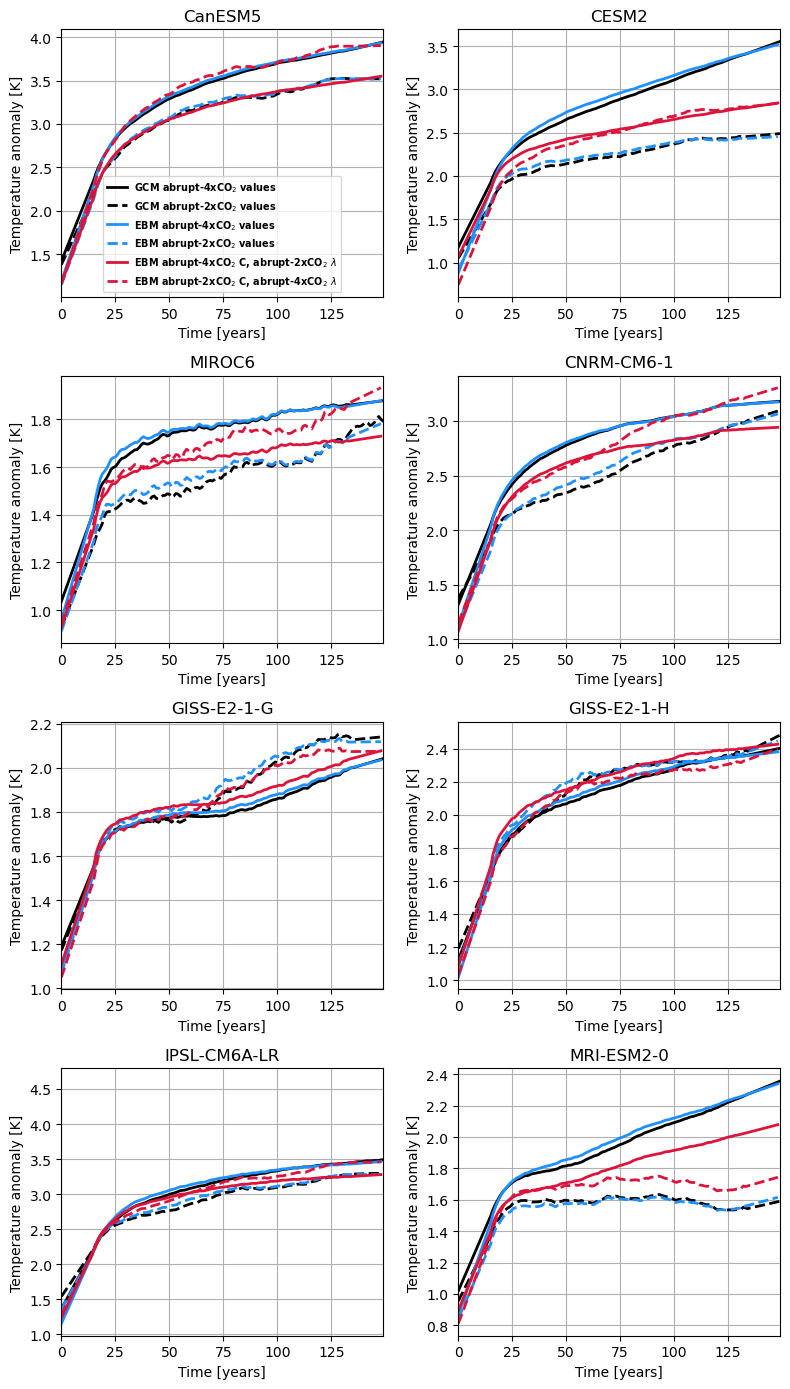

In [45]:
## 1 Layer Model Code; Table 2c, Supplemental Figure S1, & Table S5-6 ##

conversion = 31540000

# Construct Figure
fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

fig1.set_figheight(14)
fig1.set_figwidth(8)

# Radiative Feedback Parameter for Years 1-150
lambdas = {'CESM2': (1.205901844217419, 0.6344528058375946),
           'MRI-ESM2-0': (1.4043209676250203, 1.069429084906938),
           'MIROC6': (1.6163703304101067, 1.4619268470664206),
           'CanESM5': (0.756680579978647, 0.6591817382870305),
           'CNRM-CM6-1': (0.7772923346481381, 0.7316005656244611),
           'GISS-E2-1-G': (1.436084119071965, 1.4450828349197025),
           'GISS-E2-1-H': (1.266947176819093, 1.1737793670807213),
           'IPSL-CM6A-LR': (0.9301556849830722, 0.7688599288813946)}

# ERF for years 1-150
ERF_2x = {'CanESM5': 3.530,
          'CESM2': 4.061,
          'MIROC6': 3.517,
          'CNRM-CM6-1': 3.266,
          'GISS-E2-1-G': 3.779,
          'GISS-E2-1-H': 3.756, 
          'IPSL-CM6A-LR': 3.694, 
          'MRI-ESM2-0': 3.476}

ERF_4x = {'CanESM5': 3.550,
          'CESM2': 3.165,
          'MIROC6': 3.536,
          'CNRM-CM6-1': 3.385,
          'GISS-E2-1-G': 3.720,
          'GISS-E2-1-H': 3.470, 
          'IPSL-CM6A-LR': 3.360, 
          'MRI-ESM2-0': 3.185} ## check how these were normalized

# Time 
N = 1 
time_step = 1.0 / N
years = int(149)
time_vals = np.array(range(years*N)) # in years

# Initial Temperatures

T_upper_initial = 0
T_deep_initial  = 0

# Forcing function

def forcing_CO2_abrupt(time): # forcing #2
    # input time (in years, integer)
    # return forcing by CO2 at that year 
    # based on an abrupt, constant 4xCO2 concentration
    
    forcing = ERF * conversion #(ERF/np.log(2))*np.log(co2_ini/co2_pi)
    return forcing

## 1 Layer Ocean Model Functions ##

def find_upper_ocean_temp_single_layer(time, temp_prev, C_upper, dC, which_forcing, forcing_prev=None):
    # which forcing is an integer flag to decide which forcing to use 
    # forcing_previous is for inputting a saved forcing scenario from a previous run
    
    if which_forcing == 1:
        F = forcing_CO2_perturbation(time)
    elif which_forcing == 2:
        F = forcing_CO2_abrupt(time)
    
    # find new temp
    dT_upper = (time_step*(F - rad_feedback_param*temp_prev) - temp_prev*dC)/C_upper
    temp_upper_new = temp_prev + dT_upper
    
    return temp_upper_new, F
    
def find_next_temperatures_single_layer(time, temp_prev, C_upper, dC, which_forcing, forcing_prev=None):

    if which_forcing < 5:
        temp_upper_new, F = find_upper_ocean_temp_single_layer(time, temp_prev, C_upper, dC, which_forcing, None)
        
    temp_new = temp_upper_new
    
    return temp_new, F

def find_temp_versus_time_single_layer(time_values, initial_params, which_forcing, forcing_prev=None):
    # initial parameters
    temp_upper_ini = initial_params
    temp_prev = temp_upper_ini
    
    # store values with respect to time
    temp_upper_vals = []
    forcing_vals    = []
    
    # iteration for temperature
    for time in time_values:
        if time == 0:
            # intial values
            temp_upper_vals.append(temp_upper_ini)
            
            if which_forcing == 1:
                F = forcing_CO2_perturbation(time)
            elif which_forcing == 2:
                F = forcing_CO2_abrupt(time)
                
            forcing_vals.append(F)
            
        elif time > 0:
            # evaluate new temps
            if which_forcing < 5:
                temp_new, F = find_next_temperatures_single_layer(time, temp_prev, C_upper[time], dC[time], which_forcing, None)
                
            # store values
            temp_upper_vals.append(temp_new)
            forcing_vals.append(F)
            
            # progress to next timestep
            temp_prev = temp_new
    
    return np.array(temp_upper_vals), np.array(forcing_vals)

## Run the Model ##

# Store Temperature Values

vals_2x = []  # abrupt-2xCO2 values for C and lambda
vals_4x = []  # abrupt-4xCO2 values for C and lambda
vals_ex1 = [] # abrupt-4xCO2 C, abrupt-2xCO2 lambda
vals_ex2 = [] # abrupt-2xCO2 C, abrupt-4xCO2 lambda

print('Model, Lambda, Heat Capacity, Residual, Fit Error')

for i, model in enumerate(model_list):
    
    temp_data2 =  data['abrupt-2xCO2'][model]['tas'] - data_pi['tas'][model]
    temp_data4 = (data['abrupt-4xCO2'][model]['tas'] - data_pi['tas'][model])*normalize

    # 4x values
    C_upper = heat_capacity_4x[model].values * conversion
    dC = np.insert(np.diff(C_upper), 0, 0)
    rad_feedback_param = lambdas[model][1] * conversion # 0 abrupt-2x, 1 abrupt-4x
    ERF = ERF_4x[model] 
    upper_vals_1, forcing_vals_1 = find_temp_versus_time_single_layer(time_vals, 0, 2, None)
    
    # 2x values
    C_upper = heat_capacity_2x[model].values * conversion
    dC = np.insert(np.diff(C_upper), 0, 0)
    rad_feedback_param = lambdas[model][0] * conversion # 0 abrupt-2x, 1 abrupt-4x
    ERF = ERF_2x[model]
    upper_vals_2, forcing_vals_2 = find_temp_versus_time_single_layer(time_vals, 0, 2, None)

    # Abrupt 4xCO2 C, Abrupt 2xCO2 lambda
    C_upper = heat_capacity_4x[model].values * conversion
    dC = np.insert(np.diff(C_upper), 0, 0)
    rad_feedback_param = lambdas[model][0] * conversion # 0 abrupt-2x, 1 abrupt-4x
    ERF = ERF_2x[model]
    upper_vals_3, forcing_vals_3 = find_temp_versus_time_single_layer(time_vals, 0, 2, None)
        
    # Abrupt 2xCO2 C, abrupt 4xCO2 lambda
    C_upper = heat_capacity_2x[model].values * conversion
    dC = np.insert(np.diff(C_upper), 0, 0)
    rad_feedback_param = lambdas[model][1] * conversion # 0 abrupt-2x, 1 abrupt-4x
    ERF = ERF_4x[model]
    upper_vals_4, forcing_vals_4 = find_temp_versus_time_single_layer(time_vals, 0, 2, None)
    
    # relative importance using final 20 years
    period = 20
    feedback = (np.mean(upper_vals_1[-period:] - np.mean(upper_vals_3[-period:])) / (np.mean(upper_vals_1[-period:]) - np.mean(upper_vals_2[-period:])))
    heatcapa = (np.mean(upper_vals_1[-period:] - np.mean(upper_vals_4[-period:])) / (np.mean(upper_vals_1[-period:]) - np.mean(upper_vals_2[-period:])))
    residual = 1 - feedback - heatcapa
    
    print(model, feedback*100, heatcapa*100, residual*100, np.mean(abs(upper_vals_2 - temp_data2[1:150])), np.mean(abs(upper_vals_1 - temp_data4[1:150])))

    
    if model == 'CESM2':
        CESM_model_vals_4x = upper_vals_1
        CESM_model_vals_2x = upper_vals_2
        CESM_model_vals_ex1 = upper_vals_3
        CESM_model_vals_ex2 = upper_vals_4
        
    elif model == 'MRI-ESM2-0':
        MRI_model_vals_4x = upper_vals_1
        MRI_model_vals_2x = upper_vals_2
        MRI_model_vals_ex1 = upper_vals_3
        MRI_model_vals_ex2 = upper_vals_4
        
    else:
        vals_4x.append(upper_vals_1)
        vals_2x.append(upper_vals_2)
        vals_ex1.append(upper_vals_3)
        vals_ex2.append(upper_vals_4)
        
    ## Plotting

    axi = axs[i]
    
    axi.plot(savgol_filter(temp_data4, 31, 1), color='k', linestyle='solid', linewidth=2, label='GCM abrupt-4xCO$_2$ values')
    axi.plot(savgol_filter(temp_data2, 31, 1), color='k', linestyle='dashed', linewidth=2, label='GCM abrupt-2xCO$_2$ values')
    
    axi.plot(time_vals*time_step, savgol_filter(upper_vals_1, 31, 1), color='dodgerblue', linestyle='solid', linewidth=2, label='EBM abrupt-4xCO$_2$ values')

    axi.plot(time_vals*time_step, savgol_filter(upper_vals_2, 31, 1), color='dodgerblue', linestyle='dashed', linewidth=2, label='EBM abrupt-2xCO$_2$ values')

    axi.plot(time_vals*time_step, savgol_filter(upper_vals_3, 31, 1), color='crimson', linestyle='solid', linewidth=2, label='EBM abrupt-4xCO$_2$ C, abrupt-2xCO$_2$ $\\lambda$')

    axi.plot(time_vals*time_step, savgol_filter(upper_vals_4, 31, 1), color='crimson', linestyle='dashed', linewidth=2, label='EBM abrupt-2xCO$_2$ C, abrupt-4xCO$_2$ $\\lambda$')
    
    axi.grid()
    axi.set_xlabel('Time [years]')
    axi.set_title(model)
    axi.set_ylabel('Temperature anomaly [K]')
    axi.set_xlim((0, 149))
    legend_properties = {'weight':'bold', 'size':7}
    ax1.legend(loc='lower center', prop=legend_properties)
                  
model_average_4x = np.mean(vals_4x, axis=0)
model_average_2x = np.mean(vals_2x, axis=0)
model_average_ex1 = np.mean(vals_ex1, axis=0)
model_average_ex2 = np.mean(vals_ex2, axis=0)
plt.tight_layout()

plt.savefig('./Figures/EBM_ensemble.png', dpi=300)

# Global Mean Figures

Model, Experiment, Years 21-150 Regression 

CanESM5 8.736631568808022
CanESM5 abrupt-2xCO2 6.5135981369992475
CanESM5 abrupt-4xCO2 7.838880680240607
CanESM5 percent difference warming 0.08736631568808022


CESM2 44.797835130962085
CESM2 abrupt-2xCO2 4.165990919317436
CESM2 abrupt-4xCO2 12.289440181409729
CESM2 percent difference warming 0.4479783513096208


MIROC6 3.94481090519465
MIROC6 abrupt-2xCO2 2.788246793142436
MIROC6 abrupt-4xCO2 1.8425054616033327
MIROC6 percent difference warming 0.0394481090519465


CNRM-CM6-1 0.31794753526928177
CNRM-CM6-1 abrupt-2xCO2 7.781586511960224
CNRM-CM6-1 abrupt-4xCO2 5.154983082299707
CNRM-CM6-1 percent difference warming 0.0031794753526928174


GISS-E2-1-G -4.932543901776265
GISS-E2-1-G abrupt-2xCO2 4.25981656162668
GISS-E2-1-G abrupt-4xCO2 2.540874960005567
GISS-E2-1-G percent difference warming -0.04932543901776265


GISS-E2-1-H 5.715664806562313
GISS-E2-1-H abrupt-2xCO2 3.8663791373835945
GISS-E2-1-H abrupt-4xCO2 4.17807104514887
GISS-E2-1-H 

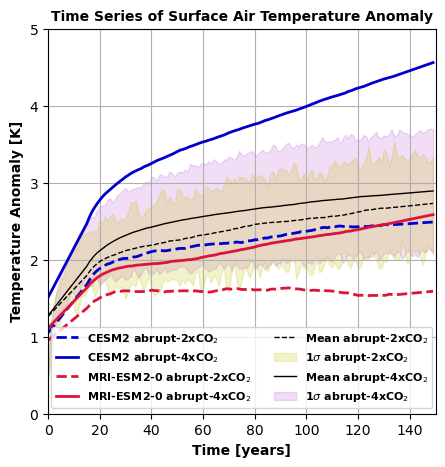

In [64]:
## Figure 1a, Table 1b ##

fig1, (ax1) = plt.subplots(1, 1)
fig1.set_figheight(5)
fig1.set_figwidth(5)

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

temp_sum_list2 = []
temp_sum_list4 = []
temp_mean_list2 = []
temp_mean_list4 = []

print('Model, Experiment, Years 21-150 Regression \n')

for model in model_list:
    
    temp_data2 =  data['abrupt-2xCO2'][model]['tas'] - data_pi['tas'][model]
    temp_data4 = (data['abrupt-4xCO2'][model]['tas'] - data_pi['tas'][model]) * normalize_model[model]
    temp_data4_unscaled = data['abrupt-4xCO2'][model]['tas'] - data_pi['tas'][model]
        
    if model == 'CESM2':
        ax1.plot(time, signal.savgol_filter(temp_data2[0:150], 31, 1), linestyle='dashed', color='mediumblue', linewidth=2, label='CESM2 abrupt-2xCO$_2$')
        ax1.plot(time, signal.savgol_filter(temp_data4[0:150], 31, 1), linestyle='solid', color='mediumblue', linewidth=2, label='CESM2 abrupt-4xCO$_2$')
            
    elif model == 'MRI-ESM2-0':
        ax1.plot(time, signal.savgol_filter(temp_data2[0:150], 31, 1), linestyle='dashed', color='crimson', linewidth=2, label='MRI-ESM2-0 abrupt-2xCO$_2$')
        ax1.plot(time, signal.savgol_filter(temp_data4[0:150], 31, 1), linestyle='solid', color='crimson', linewidth=2, label='MRI-ESM2-0 abrupt-4xCO$_2$')
            
    else:
        temp_sum_list2.append(temp_data2[0:150])
        temp_sum_list4.append(temp_data4[0:150])

    # final 20 year percent difference
    difference = (np.mean(temp_data4[131:150]) - np.mean(temp_data2[131:150])) / np.mean(temp_data4[131:150])
    print(model, 100*difference)
    
    print(model, 'abrupt-2xCO2', stats.linregress(range(21, 150), temp_data2[21:150])[0]*1000)#, stats.linregress(range(30, 150), temp_mean2[30:150])[3])
    print(model, 'abrupt-4xCO2', stats.linregress(range(21, 150), temp_data4[21:150])[0]*1000)#, stats.linregress(range(30, 150), temp_mean4[30:150])[3])
    print(model, 'percent difference warming',  difference)
    
    temp_mean_list4.append(np.mean(temp_data4_unscaled[0:150]))
    temp_mean_list2.append(np.mean(temp_data2[0:150]))
    
    print('\n')
    
    
temp_mean2 = np.mean(temp_sum_list2, axis=0)
temp_stde2 = np.std(temp_sum_list2, axis=0)

temp_mean4 = np.mean(temp_sum_list4, axis=0)
temp_stde4 = np.std(temp_sum_list4, axis=0)

difference = (np.mean(temp_mean4[131:150]) - np.mean(temp_mean2[131:150])) / np.mean(temp_mean2[131:150])
print(difference)
              
print('ensemble', 'abrupt-2xCO2', stats.linregress(range(21, 150), temp_mean2[21:150]))# [0], stats.linregress(range(30, 150), temp_mean2[30:150])[3])
print('ensemble', 'abrupt-4xCO2', stats.linregress(range(21, 150), temp_mean4[21:150]))# [0], stats.linregress(range(30, 150), temp_mean4[30:150])[3])
print('ensemble', 'percent difference warming',  difference)

time = range(0, 150)

ax1.plot(time, signal.savgol_filter(temp_mean2, 31, 1), color='k', linewidth=1, linestyle='dashed', label='Mean abrupt-2xCO$_2$', zorder=2)
ax1.fill_between(range(150), temp_mean2 - temp_stde2, temp_mean2 + temp_stde2, alpha = 0.2, color='y', zorder=1, label='1$\\sigma$ abrupt-2xCO$_2$')

ax1.plot(time, signal.savgol_filter(temp_mean4, 31, 1), color='k', linewidth=1, linestyle="solid",  label='Mean abrupt-4xCO$_2$', zorder=2)
ax1.fill_between(range(150), temp_mean4 - temp_stde4, temp_mean4 + temp_stde4, alpha = 0.2, color='mediumorchid', zorder=0, label='1$\\sigma$ abrupt-4xCO$_2$')

ax1.set_ylim([0, 5])
ax1.set_xlim([0, 150])
legend_properties = {'weight':'bold', 'size':8}
ax1.legend(loc='lower center', ncol=2, prop=legend_properties)
ax1.grid(zorder=0)
ax1.set_xlabel('Time [years]', fontweight='bold')
ax1.set_ylabel('Temperature Anomaly [K]', fontweight='bold')
ax1.set_title('Time Series of Surface Air Temperature Anomaly', fontsize=10, fontweight='bold')

plt.savefig('./Figures/tas_timeseries_new.png', dpi=300)

print('\n')
print(temp_mean_list2, temp_mean_list4)

In [47]:
## Statistical Significant in Temperature Time Series, 1 ##

# t-test comparing abrupt-2xCO2 to abrupt-4xCO2 for each model

all_temps_2x = []
all_temps_4x = []
temps_2x_exclude = []
temps_4x_exclude = []

start = 0

print('Statistical Significance of Warming Difference \n Models compared to themselves at different forcings (p-value < 0.05)')
for i, model in enumerate(model_list):
    temp_data2 =  data['abrupt-2xCO2'][model]['tas'] - data_pi['tas'][model]
    temp_data4 = (data['abrupt-4xCO2'][model]['tas'] - data_pi['tas'][model]) * normalize_model[model]
    
    if model not in ['CESM2', 'MRI-ESM2-0']:
        temps_2x_exclude.append(temp_data2[start:150]) # 6 model ensemble
        temps_4x_exclude.append(temp_data4[start:150])
        
        
    all_temps_2x.append(temp_data2[start:150]) # 8 model ensemble
    all_temps_4x.append(temp_data4[start:150])
    
    # compare each model to themself at different forcings; significance of mean final temperature
    pval = stats.ttest_ind(temp_data2[130:150], temp_data4[130:150], axis=0)[1]
    print(model, pval, pval < 0.05)
    
all_temps_2x = np.array(all_temps_2x)
all_temps_4x = np.array(all_temps_4x)
temps_2x_exclude = np.array(temps_2x_exclude)
temps_4x_exclude = np.array(temps_4x_exclude)

Statistical Significance of Warming Difference 
 Models compared to themselves at different forcings (p-value < 0.05)
CanESM5 4.1968864767738806e-16 True
CESM2 6.857075414558331e-43 True
MIROC6 0.031777978125168575 True
CNRM-CM6-1 0.832519440135877 False
GISS-E2-1-G 0.0013025701340244559 True
GISS-E2-1-H 4.299946641058296e-06 True
IPSL-CM6A-LR 9.806916510639408e-19 True
MRI-ESM2-0 7.713494527751252e-33 True


CanESM5 0.29459131798285315 5.597235041674209
CESM2 1.7866447407630757 33.94625007449843
MIROC6 0.5814396938386043 11.04735418293348
CNRM-CM6-1 0.7761860818637528 14.747535555411302
GISS-E2-1-G 1.0596143779205573 20.13267318049059
GISS-E2-1-H 0.4802168928114833 9.124120963418182
IPSL-CM6A-LR 0.16383112322585958 3.1127913412913326
MRI-ESM2-0 1.3787140246589746 26.195566468520518


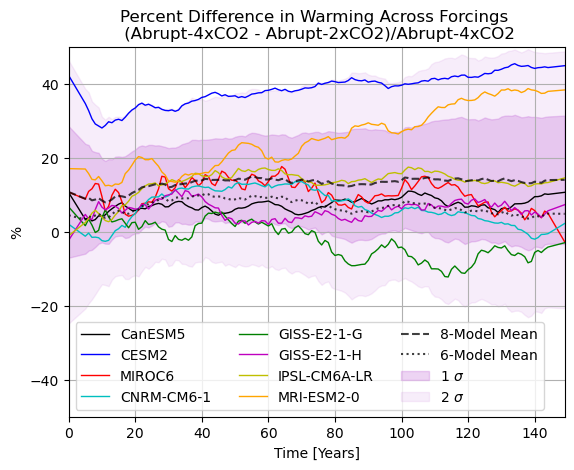

In [48]:
## Statistical Significant in Temperature Time Series, 2 ##

## How does the percent difference in warming compare to the ensemble mean?

colors   = ['k', 'b', 'r', 'c', 'g', 'm', 'y', 'orange']
stddev     = np.std((all_temps_4x - all_temps_2x)/all_temps_4x, axis=0)*100
ensemble_8 = np.mean((all_temps_4x - all_temps_2x)/all_temps_4x, axis=0)*100
ensemble_6 = np.mean((temps_4x_exclude - temps_2x_exclude)/temps_4x_exclude, axis=0)*100


plt.figure()
for i, model in enumerate(model_list):
    temp_data2 =  data['abrupt-2xCO2'][model]['tas'] - data_pi['tas'][model]
    temp_data4 = (data['abrupt-4xCO2'][model]['tas'] - data_pi['tas'][model]) * normalize_model[model]
    percent_difference = (temp_data4[0:150] - temp_data2[0:150]) / temp_data4[0:150]
    plt.plot(savgol_filter(percent_difference*100, 11, 1), color=colors[i], label=model, linewidth=1)
    
    # uses sigma
    std_away_from_mean = np.mean(np.abs((percent_difference[131:150]*100 - ensemble_8[131:150]))/stddev[131:150])
    
    # uses sigma/N
    std_away_sample_size = np.mean(np.abs((150-131)*(percent_difference[131:150]*100 - ensemble_8[131:150]))/stddev[131:150])
    
    print(model, std_away_from_mean, std_away_sample_size)
    
plt.grid()
plt.ylim([-50, 50])
plt.xlim([0, 149])
plt.plot(savgol_filter(ensemble_8, 11, 1), linestyle='dashed', color='k', label='8-Model Mean', alpha=0.75)
plt.plot(savgol_filter(ensemble_6, 11, 1), linestyle='dotted', color='k', label='6-Model Mean', alpha=0.75)
plt.fill_between(np.arange(0, 150), savgol_filter(ensemble_8-stddev, 11, 1), savgol_filter(ensemble_8+stddev, 11, 1), color='mediumorchid', alpha=0.25, label='1 $\\sigma$', zorder=0)
plt.fill_between(np.arange(0, 150), savgol_filter(ensemble_8-2*stddev, 11, 1), savgol_filter(ensemble_8+2*stddev, 11, 1), color='mediumorchid', alpha=0.10, label='2 $\\sigma$', zorder=0)
plt.title('Percent Difference in Warming Across Forcings \n (Abrupt-4xCO2 - Abrupt-2xCO2)/Abrupt-4xCO2')
plt.ylabel('%')
plt.xlabel('Time [Years]')
plt.legend(ncol=3)

CanESM5 0.2791051815146185 0.304307456352439
CESM2 0.18330156700706834 0.4611508222573248
MIROC6 0.18874041406311431 0.10535156180486104
CNRM-CM6-1 0.3090826182730072 0.2053100095025949
GISS-E2-1-G 0.21098053212477075 0.11197463639803187
GISS-E2-1-H 0.19803768330816252 0.1680773078371195
IPSL-CM6A-LR 0.2596863281449818 0.26701369750732457
MRI-ESM2-0 0.1045551878861563 0.21443638095081527


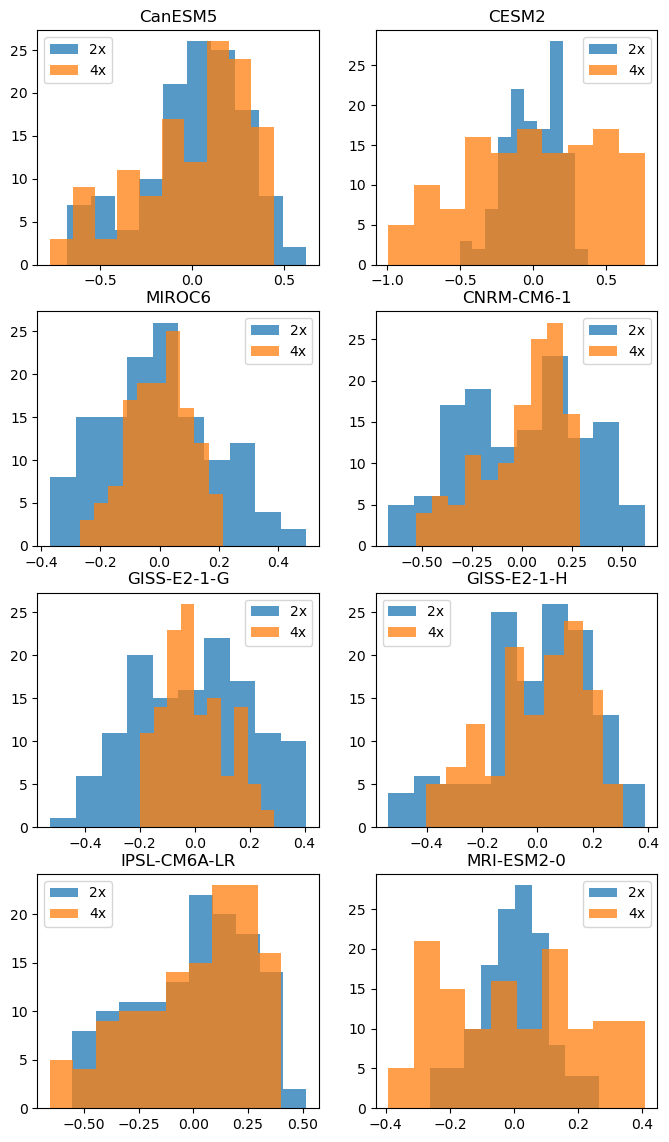

In [49]:
## Statistical Significant in Temperature Time Series, 3 ##

# Check if Temperature Anomalies follow a normal distribution around their mean value
# Plotting the distribution of the slow period difference from the mean temperature

final_temps_4 = []
final_temps_2 = []

fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

fig1.set_figheight(14)
fig1.set_figwidth(8)

start = 21
for i, model in enumerate(model_list):
    axi = axs[i]
    
    temp_data2 =  data['abrupt-2xCO2'][model]['tas'] - data_pi['tas'][model]
    temp_data4 =  (data['abrupt-4xCO2'][model]['tas'] - data_pi['tas'][model]) * normalize_model[model]
    
    mean_final_temp2 = np.mean(temp_data2[start:150])
    mean_final_temp4 = np.mean(temp_data4[start:150])
    sum_2x = np.sum(temp_data2[start:150])
    sum_4x = np.sum(temp_data4[start:150])
    
    variance2 = temp_data2[start:150] - mean_final_temp2
    variance4 = temp_data4[start:150] - mean_final_temp4
    
    print(model, np.std(temp_data2[start:150]), np.std(temp_data4[start:150]))
    
    final_temps_4.append(mean_final_temp4)
    final_temps_2.append(mean_final_temp2)

    axi.set_title(model)
    axi.hist(variance2, label='2x', alpha=0.75)
    axi.hist(variance4, label='4x', alpha=0.75)
    axi.legend()

CanESM5 2xCO2 -0.756680579978647 3.53026437405825 4.665461844095261 True 0.4733256530612515
CanESM5 4xCO2 -0.6591817382870302 7.458426035491911 5.351840486290191 True
stde 2x and 4x:  0.037338041652624256 0.015178956288175602
95% CI, 2x and 4x:  -0.8298631416177905 -0.6834980183395035 -0.6889324926118544 -0.629430983962206
t-statistic:  2.418998389119792 

CESM2 2xCO2 -1.2059018442174194 4.061805917327779 3.3682724152094843 True 0.6109376246321006
CESM2 4xCO2 -0.6344528058375952 6.648478917587946 6.402715192162089 True
stde 2x and 4x:  0.08700203607878346 0.02712075758079149
95% CI, 2x and 4x:  -1.376425834931835 -1.0353778535030038 -0.6876094906959466 -0.5812961209792439
t-statistic:  6.270621250411211 

MIROC6 2xCO2 -1.616370330410106 3.517374801665873 2.1760946334454454 True 0.4735464567550015
MIROC6 4xCO2 -1.4619268470664222 7.427729109766426 2.4082898573852662 True
stde 2x and 4x:  0.12314365330254487 0.06446329105100493
95% CI, 2x and 4x:  -1.857731890883094 -1.375008769937118 -1

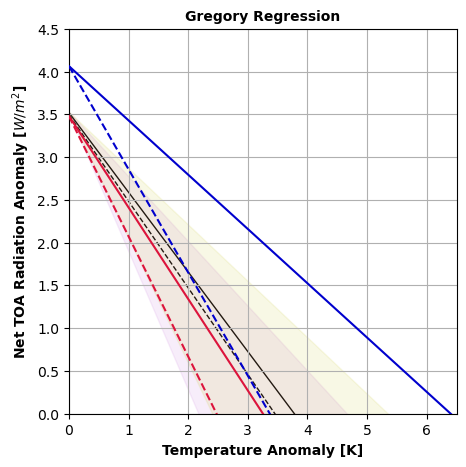

In [58]:
## Figure 1b, Table 1a, c, d, Supplemental Table S4 ##

fig1, ax1 = plt.subplots(1, 1)
fig1.set_figheight(5)
fig1.set_figwidth(5)

temps_4x = []
temps_2x = []
rtmts_4x = []
rtmts_2x = []

#print('Model, Exper, Lambda Years 1-150, ERF Years 1-150, ECS Years 1-150, p-val<5%, stderr 1-150, ERF Ratio or Lambda diff < stde')

# Plot CESM2, MRI-ESM2-0, and print lambda, ERF, ECS
for i, model in enumerate(model_list):
    
    temp2 =  data['abrupt-2xCO2'][model]['tas'] - data_pi['tas'][model]
    temp4 = (data['abrupt-4xCO2'][model]['tas'] - data_pi['tas'][model]) * normalize_model[model]
    temp4_raw = (data['abrupt-4xCO2'][model]['tas'] - data_pi['tas'][model])
    
    if model in model_list1: # has rtmt data 

        rtmt2 =  data['abrupt-2xCO2'][model]['rtmt'] - data_pi['rtmt'][model]
        rtmt4 = (data['abrupt-4xCO2'][model]['rtmt'] - data_pi['rtmt'][model]) * normalize_model[model]
        rtmt4_raw = (data['abrupt-4xCO2'][model]['rtmt'] - data_pi['rtmt'][model])
        
    elif model in model_list2: # use rsdt, rsut, rlut
        
        rtmt2 =  data['abrupt-2xCO2'][model]['rsdt'] - data['abrupt-2xCO2'][model]['rsut'] - data['abrupt-2xCO2'][model]['rlut'] -data_pi['rtmt'][model]
        rtmt4 = (data['abrupt-4xCO2'][model]['rsdt'] - data['abrupt-4xCO2'][model]['rsut'] - data['abrupt-4xCO2'][model]['rlut'] -data_pi['rtmt'][model]) * normalize_model[model]
        rtmt4_raw = (data['abrupt-4xCO2'][model]['rsdt'] - data['abrupt-4xCO2'][model]['rsut'] - data['abrupt-4xCO2'][model]['rlut'] -data_pi['rtmt'][model])

        
    ## regression
    m1, c1, r1, p1, stde1 = stats.linregress(temp2[0:150], rtmt2[0:150]) # Years 1-150
    m2, c2, r2, p2, stde2 = stats.linregress(temp4[0:150], rtmt4[0:150])
    m3, c3, r3, p3, stde3 = stats.linregress(temp4_raw[0:150], rtmt4_raw[0:150])
    
    n1, b1, _, p3, _ = stats.linregress(temp2[0:20], rtmt2[0:20]) # Years 1-20
    n2, b2, _, p4, _ = stats.linregress(temp4[0:20], rtmt4[0:20])
     
    # table 1 parameters
    print(model, '2xCO2', m1, c1, -c1/m1, p1<0.05,  c1/c3)
    print(model, '4xCO2', m2, c3, -c2/m2, p2<0.05)
    print('stde 2x and 4x: ', stde1, stde2)
    print('95% CI, 2x and 4x: ', m1-1.96*stde1, m1+1.96*stde1, m2-1.96*stde2, m2+1.96*stde2) 
    tstat = (m1 - m2) / (np.sqrt(stde1**2 + stde2**2))
    print("t-statistic: ", np.abs(tstat), '\n')
    
    # CI analysis
    #print(model, '4xCO2', round(m2, 3), round(m2-(1.96*stde2), 3), round(m2+(1.96*stde2), 3))
    #print(model, '2xCO2', round(m1, 3), round(m1-(1.96*stde1), 3), round(m1+(1.96*stde1), 3), (m1+(1.96*stde1)) < (m2-(1.96*stde2)))
    #print('\n')


    # Plot CESM2, MRI-ESM2-0
    if model == 'CESM2': 
        ax1.plot(np.linspace(0, 14, 50), m1*np.linspace(0, 14, 50)+c1, linestyle="dashed", color="mediumblue", linewidth=1.5, zorder=5, label='CESM2 abrupt-2xCO$_2$')
        ax1.plot(np.linspace(0, 14, 50), m2*np.linspace(0, 14, 50)+c2, linestyle="solid", color="mediumblue", linewidth=1.5, zorder=4, label='CESM2 abrupt-4xCO$_2$')
        
    elif model == "MRI-ESM2-0":
        ax1.plot(np.linspace(0, 14, 50), m1*np.linspace(0, 14, 50)+c1, linestyle="dashed", color="crimson", linewidth=1.5, zorder=5, label='MRI-ESM2-0 abrupt-2xCO$_2$')
        ax1.plot(np.linspace(0, 14, 50), m2*np.linspace(0, 14, 50)+c2, linestyle="solid", color="crimson", linewidth=1.5, zorder=4, label='MRI-ESM2-0 abrupt-4xCO$_2$')
        
    # plot
    elif model == 'MIROC6': # lower bound
        Y1_2x = m1*np.linspace(0, 14, 50)+c1
        Y1_4x = m2*np.linspace(0, 14, 50)+c2

    elif model == 'CanESM5': # upper bound 
        Y2_2x = m1*np.linspace(0, 14, 50)+c1
        Y2_4x = m2*np.linspace(0, 14, 50)+c2
            
    else: # all other models
        temps_4x.append(temp4[0:150])
        temps_2x.append(temp2[0:150])
        rtmts_4x.append(rtmt4[0:150])
        rtmts_2x.append(rtmt2[0:150])
        

temp_mean2 = np.mean(np.array(temps_2x), axis=0)
temp_mean4 = np.mean(np.array(temps_4x), axis=0)
rtmt_mean2 = np.mean(np.array(rtmts_2x), axis=0)
rtmt_mean4 = np.mean(np.array(rtmts_4x), axis=0)

m3, c3, r3, p3, stde3 = stats.linregress(temp_mean2, rtmt_mean2) # Years 1-150
m4, c4, r4, p4, stde4 = stats.linregress(temp_mean4, rtmt_mean4)

n3, b3, _, _, _ = stats.linregress(temp_mean2[0:20], rtmt_mean2[0:20]) # Years 1-20
n4, b4, _, _, _ = stats.linregress(temp_mean4[0:20], rtmt_mean4[0:20])

ax1.plot(np.linspace(0, 14, 50), m3*np.linspace(0, 14, 50)+c3, linestyle="dashed", zorder=0, linewidth=1, color='k', label='Mean abrupt-2xCO$_2$')     
ax1.plot(np.linspace(0, 14, 50), m4*np.linspace(0, 14, 50)+c4, linestyle="solid", zorder=0, linewidth=1, color='k', label="Mean abrupt-4xCO$_2$")

ax1.fill_between(np.linspace(0, 14, 50), Y1_2x, Y2_2x, color='mediumorchid', alpha=0.1, label='1$\\sigma$ abrupt-2xCO$_2$')
ax1.fill_between(np.linspace(0, 14, 50), Y1_4x, Y2_4x, color='y', alpha=0.1, label='1$\\sigma$ abrupt-4xCO$_2$')

ax1.set_ylim([0, 4.5])
ax1.set_xlim([0, 6.5])
ax1.grid()
legend_properties = {'weight':'bold', 'size':8}
#ax1.legend(loc='upper center', ncol=2, prop=legend_properties)
ax1.grid(zorder=0)
ax1.set_ylabel('Net TOA Radiation Anomaly [$W/m^2$]', fontweight='bold')
ax1.set_xlabel('Temperature Anomaly [K]', fontweight='bold')
ax1.set_title('Gregory Regression', fontsize=10, fontweight='bold')

plt.savefig('./Figures/gregory_regression_new.png', dpi=300)

Last 20 year average heat capacity 
Model, Abrupt-2x-CO2, Abrupt-4xCO2
CanESM5 1.5366494677883826 1.5533655661247925
CESM2 2.6059077358443363 1.7866149515645202
MIROC6 2.643076645480589 2.4159244415099748
CNRM-CM6-1 1.9312106548513288 1.8867086239065696
GISS-E2-1-G 2.264275296034579 2.490566768412586
GISS-E2-1-H 1.9123943379795498 1.8786643111944503
IPSL-CM6A-LR 1.383244789792925 1.3333723452438664
MRI-ESM2-0 3.7143372228221785 2.1794223751657413


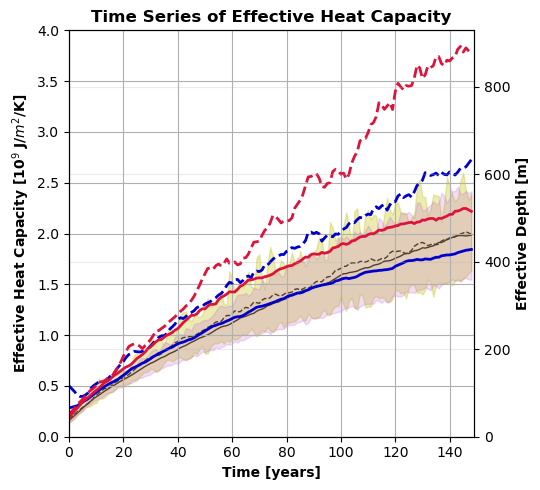

In [12]:
## Figure 1c, Table 2a ##

fig1, (ax1) = plt.subplots(1, 1)
fig1.set_figheight(5)
fig1.set_figwidth(5.5)

heat_capacity_sum_2x = []
heat_capacity_sum_4x = []

seconds_per_year = 3.15e7 # s/y
density = 1030 # kg/m^3
c_p     = 4183 # 

print('Last 20 year average heat capacity \nModel, Abrupt-2x-CO2, Abrupt-4xCO2')

for i, model in enumerate(model_list):
    
    if model == "CESM2":
        ax1.plot(np.arange(0, 149), signal.savgol_filter(heat_capacity_2x[model]*seconds_per_year/1e9, 5, 1), color="mediumblue", linestyle="dashed", label="CESM2 Abrupt-2xCO$_2$", zorder=2, linewidth=2)
        ax1.plot(np.arange(0, 149), signal.savgol_filter(heat_capacity_4x[model]*seconds_per_year/1e9, 5, 1), color="mediumblue", linestyle="solid", zorder=2, label="CESM2 Abrupt-4xCO$_2$", linewidth=2)
        
    elif model == "MRI-ESM2-0":
        ax1.plot(np.arange(0, 149), signal.savgol_filter(heat_capacity_2x[model]*seconds_per_year/1e9, 5, 1), color="crimson", linestyle="dashed", label="MRI-ESM2-0 Abrupt-2xCO$_2$", zorder=2, linewidth=2)
        ax1.plot(np.arange(0, 149), signal.savgol_filter(heat_capacity_4x[model]*seconds_per_year/1e9, 5, 1), color="crimson", linestyle="solid", zorder=2, label="MRI-ESM2-0 Abrupt-4xCO$_2$", linewidth=2)
        
    else:
        heat_capacity_sum_2x.append(heat_capacity_2x[model]*seconds_per_year/1e9)
        heat_capacity_sum_4x.append(heat_capacity_4x[model]*seconds_per_year/1e9)
        
    print(model, np.mean(heat_capacity_2x[model][-20:]*seconds_per_year/1e9), np.mean(heat_capacity_4x[model][-20:]*seconds_per_year/1e9))
 
heat_capacity_avg_2x = np.mean(heat_capacity_sum_2x, axis=0)
heat_capacity_avg_4x = np.mean(heat_capacity_sum_4x, axis=0)
heat_capacity_std_2x = np.std(heat_capacity_sum_2x, axis=0)
heat_capacity_std_4x = np.std(heat_capacity_sum_4x, axis=0)

ax1.plot(np.arange(0, 149), signal.savgol_filter(heat_capacity_avg_2x, 5, 1), color="k", linestyle="dashed", label="Ensemble Mean Abrupt-2xCO$_2$", linewidth=1, zorder=0)
ax1.plot(np.arange(0, 149), signal.savgol_filter(heat_capacity_avg_4x, 5, 1), color="k", linestyle="solid", linewidth=1, zorder=0, label="Ensemble Mean, Abrupt-4xCO$_2$")
ax1.fill_between(range(149), heat_capacity_avg_2x - heat_capacity_std_2x, heat_capacity_avg_2x + heat_capacity_std_2x, alpha = 0.3, color='y', zorder=0, label="1 $\\sigma$, Abrupt-2xCO$_2$")
ax1.fill_between(range(149), heat_capacity_avg_4x - heat_capacity_std_4x, heat_capacity_avg_4x + heat_capacity_std_4x, alpha = 0.2, color='mediumorchid', zorder=0, label="1 $\\sigma$, Abrupt-4xCO$_2$")

ax1.grid()
ax1.set_xlim(0, 149)
ax1.set_ylim(0, 4)
ax4 = ax1.twinx()
ax4.set_ylim(0, 4e9/density/c_p)
ax4.grid(alpha=0.25)
legend_properties = {'weight':'bold', 'size':8}
ax1.grid(zorder=0)
ax1.set_xlabel('Time [years]', fontweight='bold')
ax1.set_ylabel('Effective Heat Capacity [10$^9$ J/$m^2$/K]', fontweight='bold')
ax4.set_ylabel('Effective Depth [m]', fontweight='bold')
ax1.set_title('Time Series of Effective Heat Capacity', fontsize=12, fontweight='bold')
#ax1.legend(loc='upper left', ncol=1, prop=legend_properties)
plt.tight_layout()

plt.savefig('./Figures/heatcapacity_timeseries_new.png', dpi=300)

Last 20 year average AMOC Decline 
Model, Abrupt-2x-CO2, Abrupt-4xCO2, Ratio 2x/4x [%]
CanESM5 3.0343313106796117 7.984028553398058 0.3800501576848919
CESM2 15.2365432815534 20.874319519417476 0.7299180827130788
CNRM-CM6-1 10.216082058252429 16.28797317524272 0.6272162870319923
GISS-E2-1-G -0.8712258252427176 19.264815257281555 -0.045223679210389466
MRI-ESM2-0 19.15822367961165 20.2703496092233 0.9451353355491403


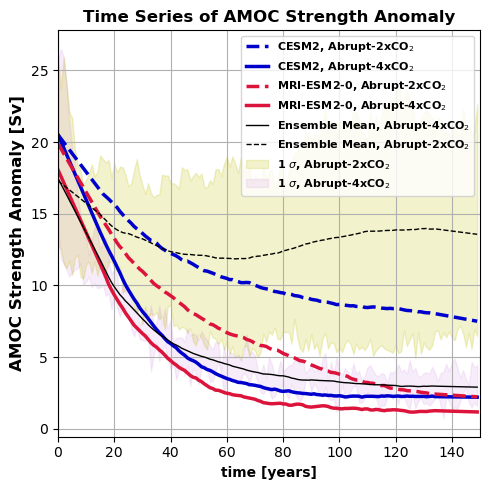

In [451]:
## Figure 1d, Table 2b ##

colors1 = ['k', 'mediumblue', 'k', 'b', 'g', 'm', 'y', 'crimson']
colors2 = ['k', 'mediumblue', 'crimson', 'b', 'g', 'm', 'y', 'crimson']

fig1 = plt.figure()

fig1.set_figheight(5)
fig1.set_figwidth(5)

AMOC_sum_4x = []  # decline
AMOC_sum_2x = []

AMOC_sum2_4x = [] # strength
AMOC_sum2_2x = []

print('Last 20 year average AMOC Decline \nModel, Abrupt-2x-CO2, Abrupt-4xCO2, Ratio 2x/4x [%]')

for i, model in enumerate(model_list):
    
    if model in ['GISS-E2-1-H', 'MIROC6', 'IPSL-CM6A-LR']: # missing streamfunction data
        continue
        
    else: # for models with streamfunction data
        
        if model != 'GISS-E2-1-G':
            initial2  = np.mean(AMOC_pi[model])/1.03e9 # need pi for all models
            initial4  = np.mean(AMOC_pi[model])/1.03e9 # need pi for all models
        
        else:
            initial2 = np.mean(AMOC_strength_2x[model][:10]/1.03e9)
            initial4 = np.mean(AMOC_strength_4x[model][:10]/1.03e9)
        
        strength2 = signal.savgol_filter(AMOC_strength_2x[model]/1.03e9, 31, 1)
        strength4 = signal.savgol_filter(AMOC_strength_4x[model]/1.03e9, 31, 1)
        
        decline2  = initial2 - np.mean(AMOC_strength_2x[model][-20:]/1.03e9)
        decline4  = initial4 - np.mean(AMOC_strength_4x[model][-20:]/1.03e9)
        
        if model == "CESM2" or model == "MRI-ESM2-0": # models to be plotted
            plt.plot(np.arange(0, 150), strength2, color=colors2[i], linestyle="dashed", zorder=2, linewidth=2.5, label="%s, Abrupt-2xCO$_2$" % model)
            plt.plot(np.arange(0, 150), strength4, color=colors2[i], linestyle="solid", zorder=2, linewidth=2.5, label="%s, Abrupt-4xCO$_2$" % model)

        else:
            try:
                AMOC_sum_4x.append(AMOC_strength_4x[model])
        
                if model != "MIROC6":
                    AMOC_sum_2x.append(AMOC_strength_2x[model])
            
            except KeyError:
                continue
            
        print(model, decline2, decline4, decline2/decline4)
            
AMOC_avg_4x = np.mean(AMOC_sum_4x, axis=0)/1.03e9
AMOC_avg_2x = np.mean(AMOC_sum_2x, axis=0)/1.03e9


AMOC_std_4x = np.std(AMOC_sum_4x, axis=0)/1.03e9
AMOC_std_2x = np.std(AMOC_sum_2x, axis=0)/1.03e9

plt.plot(np.arange(0, 150), signal.savgol_filter(AMOC_avg_4x, 31, 1), color='k', linestyle="solid", zorder=3, linewidth=1, label="Ensemble Mean, Abrupt-4xCO$_2$")
plt.plot(np.arange(0, 150), signal.savgol_filter(AMOC_avg_2x, 31, 1), color='k', linestyle="dashed", zorder=3, linewidth=1, label="Ensemble Mean, Abrupt-2xCO$_2$")
plt.fill_between(range(150), AMOC_avg_2x - AMOC_std_2x, AMOC_avg_2x + AMOC_std_2x, alpha = 0.2, color='y', zorder=0, label="1 $\\sigma$, Abrupt-2xCO$_2$")
plt.fill_between(range(150), AMOC_avg_4x - AMOC_std_4x, AMOC_avg_4x + AMOC_std_4x, alpha = 0.1, color='mediumorchid', zorder=0, label="1 $\\sigma$, Abrupt-4xCO$_2$")

plt.title('Time Series of AMOC Strength Anomaly', fontweight='bold') # \n AMOC Strength - Initial AMOC Strength')
plt.xlabel('time [years]', fontweight='bold')
legend_properties = {'weight':'bold', 'size':8}
plt.ylabel('AMOC Strength Anomaly [Sv]', fontweight='bold', fontsize=12)
plt.legend(loc='upper right', ncol=1, prop=legend_properties)
plt.grid()
plt.xlim(0, 150)
plt.tight_layout()

plt.savefig('./Figures/AMOC_timeseries.png', dpi=300)

Last 20 year average AMOC Decline 
Model, Abrupt-2x-CO2, Abrupt-4xCO2, Ratio 2x/4x [%]
CanESM5 3.0343313106796117 7.984028553398058 0.3800501576848919
CESM2 15.2365432815534 20.874319519417476 0.7299180827130788
CNRM-CM6-1 10.216082058252429 16.28797317524272 0.6272162870319923
GISS-E2-1-G -0.8712258252427176 19.264815257281555 -0.045223679210389466
MRI-ESM2-0 19.15822367961165 20.2703496092233 0.9451353355491403


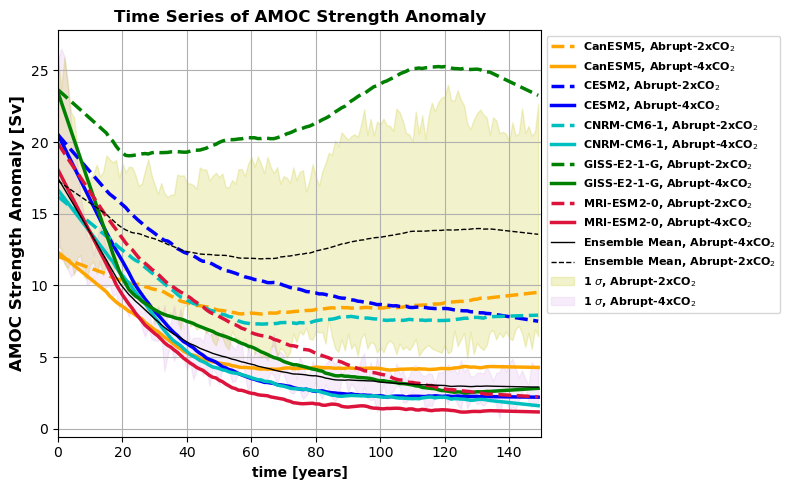

In [29]:
## Reviewer Response on AMOC Recovery ##

colors = ['orange', 'b', 'r', 'c', 'g', 'm', 'y', 'crimson']

fig1 = plt.figure()

fig1.set_figheight(5)
fig1.set_figwidth(8)

AMOC_sum_4x = []  # decline
AMOC_sum_2x = []

AMOC_sum2_4x = [] # strength
AMOC_sum2_2x = []

print('Last 20 year average AMOC Decline \nModel, Abrupt-2x-CO2, Abrupt-4xCO2, Ratio 2x/4x [%]')

for i, model in enumerate(model_list):
    
    if model in ['GISS-E2-1-H', 'MIROC6', 'IPSL-CM6A-LR']: # missing streamfunction data
        continue
        
    else: # for models with streamfunction data
        
        if model != 'GISS-E2-1-G':
            initial2  = np.mean(AMOC_pi[model])/1.03e9 # need pi for all models
            initial4  = np.mean(AMOC_pi[model])/1.03e9 # need pi for all models
        
        else:
            initial2 = np.mean(AMOC_strength_2x[model][:10]/1.03e9)
            initial4 = np.mean(AMOC_strength_4x[model][:10]/1.03e9)
        
        strength2 = signal.savgol_filter(AMOC_strength_2x[model]/1.03e9, 31, 1)
        strength4 = signal.savgol_filter(AMOC_strength_4x[model]/1.03e9, 31, 1)
        
        decline2  = initial2 - np.mean(AMOC_strength_2x[model][-20:]/1.03e9)
        decline4  = initial4 - np.mean(AMOC_strength_4x[model][-20:]/1.03e9)
        
        
        plt.plot(np.arange(0, 150), strength2, color=colors[i], linestyle="dashed", zorder=2, linewidth=2.5, label="%s, Abrupt-2xCO$_2$" % model)
        plt.plot(np.arange(0, 150), strength4, color=colors[i], linestyle="solid", zorder=2, linewidth=2.5, label="%s, Abrupt-4xCO$_2$" % model)

        if model not in ["CESM2", "MRI-ESM2-0"]: # ensemble
            try:
                AMOC_sum_4x.append(AMOC_strength_4x[model])
        
                if model != "MIROC6":
                    AMOC_sum_2x.append(AMOC_strength_2x[model])
            
            except KeyError:
                continue
            
        print(model, decline2, decline4, decline2/decline4)
            
AMOC_avg_4x = np.mean(AMOC_sum_4x, axis=0)/1.03e9
AMOC_avg_2x = np.mean(AMOC_sum_2x, axis=0)/1.03e9


AMOC_std_4x = np.std(AMOC_sum_4x, axis=0)/1.03e9
AMOC_std_2x = np.std(AMOC_sum_2x, axis=0)/1.03e9

plt.plot(np.arange(0, 150), signal.savgol_filter(AMOC_avg_4x, 31, 1), color='k', linestyle="solid", zorder=3, linewidth=1, label="Ensemble Mean, Abrupt-4xCO$_2$")
plt.plot(np.arange(0, 150), signal.savgol_filter(AMOC_avg_2x, 31, 1), color='k', linestyle="dashed", zorder=3, linewidth=1, label="Ensemble Mean, Abrupt-2xCO$_2$")
plt.fill_between(range(150), AMOC_avg_2x - AMOC_std_2x, AMOC_avg_2x + AMOC_std_2x, alpha = 0.2, color='y', zorder=0, label="1 $\\sigma$, Abrupt-2xCO$_2$")
plt.fill_between(range(150), AMOC_avg_4x - AMOC_std_4x, AMOC_avg_4x + AMOC_std_4x, alpha = 0.1, color='mediumorchid', zorder=0, label="1 $\\sigma$, Abrupt-4xCO$_2$")

plt.title('Time Series of AMOC Strength Anomaly', fontweight='bold') # \n AMOC Strength - Initial AMOC Strength')
plt.xlabel('time [years]', fontweight='bold')
legend_properties = {'weight':'bold', 'size':8}
plt.ylabel('AMOC Strength Anomaly [Sv]', fontweight='bold', fontsize=12)
plt.legend(bbox_to_anchor=(1, 1), ncol=1, prop=legend_properties)
plt.grid()
plt.xlim(0, 150)
plt.tight_layout()

#plt.savefig('./Figures/AMOC_timeseries.png', dpi=300)

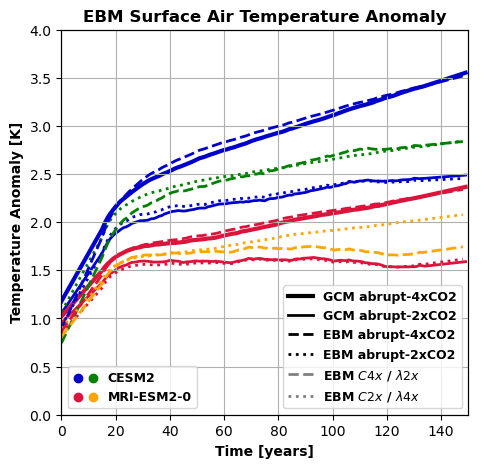

In [452]:
## Figure 1f ##

from matplotlib.legend_handler import HandlerTuple

fig1, (ax1) = plt.subplots(1, 1)
fig1.set_figheight(5)
fig1.set_figwidth(5.25)

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

temp_sum_list2 = []
temp_sum_list4 = []

for model in model_list:
    
    temp_data2 =  data['abrupt-2xCO2'][model]['tas'] - data_pi['tas'][model]
    temp_data4 = (data['abrupt-4xCO2'][model]['tas'] - data_pi['tas'][model])*normalize
    
    if model == 'CESM2':
        ax1.plot(time_vals*time_step, savgol_filter(CESM_model_vals_2x, 31, 1), color='mediumblue', linestyle='dotted', linewidth=2)#, label='CESM2 EBM abrupt-2xCO$_2$')
        ax1.plot(time_vals*time_step, savgol_filter(CESM_model_vals_ex1, 31, 1), color='green', linestyle='dotted', linewidth=2)#, label='CESM2 $C_{4x}$ / $\\lambda_{2x}$')
        ax1.plot(range(150), savgol_filter(temp_data2[0:150], 31, 1), color='mediumblue', linestyle='solid', linewidth=2, zorder=0) #,label='CESM2 GCM abrupt-2xCO$_2$'
        ax1.plot(time_vals*time_step, savgol_filter(CESM_model_vals_4x, 31, 1), color='mediumblue', linestyle='dashed', linewidth=2)#, label='CESM2 EBM $\\frac{1}{2}$ abrupt-4xCO$_2$')
        ax1.plot(time_vals*time_step, savgol_filter(CESM_model_vals_ex2, 31, 1), color='green', linestyle='dashed', linewidth=2)#, label='CESM2 $C_{2x}$ / $\\lambda_{4x}$')
        ax1.plot(range(150), savgol_filter(temp_data4[0:150], 31, 1), color='mediumblue', linewidth=3, linestyle='solid', zorder=0) #,label='CESM2 GCM $\\frac{1}{2}$ abrupt-4xCO$_2$'
        
    elif model == 'MRI-ESM2-0':
        ax1.plot(time_vals*time_step, savgol_filter(MRI_model_vals_2x, 31, 1), color='crimson', linestyle='dotted', linewidth=2)#, label='MRI-ESM2-0 EBM abrupt-2xCO$_2$')
        ax1.plot(time_vals*time_step, savgol_filter(MRI_model_vals_ex1, 31, 1), color='orange', linestyle='dotted', linewidth=2)#, label='MRI-ESM2-0 $C_{4x}$ / $\\lambda_{2x}$')
        ax1.plot(range(150), savgol_filter(temp_data2[0:150], 31, 1), color='crimson',  linestyle='solid', zorder=0, linewidth=2) #,label='MRI-ESM2-0 GCM abrupt-2xCO$_2$',
        ax1.plot(time_vals*time_step, savgol_filter(MRI_model_vals_4x, 31, 1), color='crimson', linestyle='dashed', linewidth=2)#, label='MRI-ESM2-0 EBM $\\frac{1}{2}$ abrupt-4xCO$_2$')
        ax1.plot(time_vals*time_step, savgol_filter(MRI_model_vals_ex2, 31, 1), color='orange', linestyle='dashed', linewidth=2)#, label='MRI-ESM2-0 $C_{2x}$ / $\\lambda_{4x}$')
        ax1.plot(range(150), savgol_filter(temp_data4[0:150], 31, 1), color='crimson', linewidth=3, linestyle='solid', zorder=0) #,label='MRI-ESM2-0 GCM $\\frac{1}{2}$ abrupt-4xCO$_2$'
    
    else:
        temp_sum_list2.append(temp_data2[0:150])
        temp_sum_list4.append(temp_data4[0:150])
    
temp_mean2 = np.mean(temp_sum_list2, axis=0)
temp_stde2 = np.std(temp_sum_list2, axis=0)

temp_mean4 = np.mean(temp_sum_list4, axis=0)*normalize
temp_stde4 = np.std(temp_sum_list4, axis=0)*normalize
time = range(0, 150)

ax1.set_ylim([0, 4])
ax1.set_xlim([0, 150])

# dummy plots to make legend
ax1.plot([5, 6, 7], [5, 6, 7], linestyle='solid', linewidth=3, color='k', label='GCM abrupt-4xCO2')
ax1.plot([5, 6, 7], [5, 6, 7], linestyle='solid', linewidth=2, color='k', label='GCM abrupt-2xCO2')
ax1.plot([5, 6, 7], [5, 6, 7], linestyle='dashed', linewidth=2, color='k', label='EBM abrupt-4xCO2')
ax1.plot([5, 6, 7], [5, 6, 7], linestyle='dotted', linewidth=2, color='k', label='EBM abrupt-2xCO2')
ax1.plot([5, 6, 7], [5, 6, 7], linestyle='dashed', linewidth=2, color='grey', label='EBM $C4x$ / $\\lambda 2x$')
ax1.plot([5, 6, 7], [5, 6, 7], linestyle='dotted', linewidth=2, color='grey', label='EBM $C2x$ / $\\lambda 4x$')

darkblue = ax1.scatter(5, 5, color='mediumblue', marker='o')
lightblue = ax1.scatter(5, 5, color='green', marker='o')
darkred = ax1.scatter(5, 5, color='crimson', marker='o')
lightred = ax1.scatter(5, 5, color='orange', marker='o')

ax2 = ax1.twinx()
ax2.get_yaxis().set_visible(False)
legend_properties = {'weight':'bold', 'size':9}
ax1.legend(loc='lower right', ncol=1, prop=legend_properties)
ax2.legend([(darkblue, lightblue), (darkred, lightred)], ['CESM2', 'MRI-ESM2-0'], loc='lower left', ncol=1, prop=legend_properties, handler_map={tuple: HandlerTuple(ndivide=None)})
ax1.grid(zorder=0)
ax1.set_xlabel('Time [years]', fontweight='bold')
ax1.set_ylabel('Temperature Anomaly [K]', fontweight='bold')
ax1.set_title('EBM Surface Air Temperature Anomaly', fontsize=12, fontweight='bold')

plt.savefig('./Figures/EBM_timeseries.png', dpi=300)

Last 20 year Depth of 55% Global Heat Storage 
Model, Abrupt-2x-CO2, Abrupt-4xCO2, Difference
CanESM5 643.2084958505151 560.6497764760574 82.55871937445772
CESM2 715.46631630547 565.6525042541965 149.81381205127343
CNRM-CM6-1 686.1542923903686 590.2916365251335 95.86265586523507
GISS-E2-1-G 1102.2851510504465 807.7017472401865 294.58340381026005
GISS-E2-1-H 727.3443119782017 678.5320466767174 48.81226530148433
IPSL-CM6A-LR 	 	 	 593.9089930158416
MRI-ESM2-0 951.7395573420614 816.6138648202619 135.12569252179946


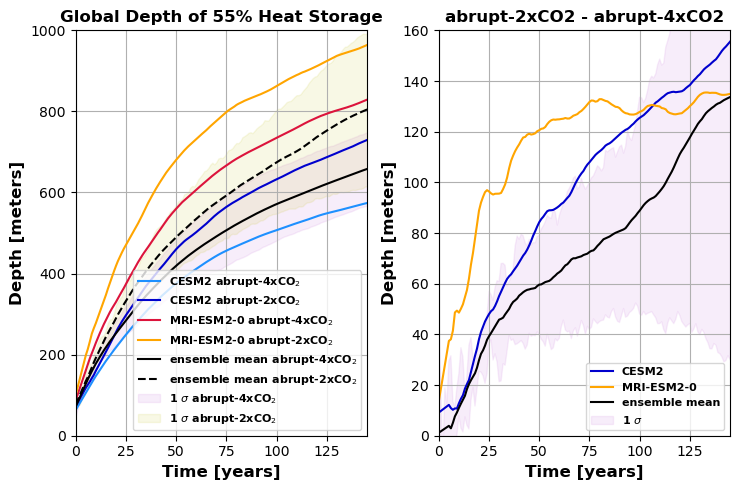

In [453]:
## Supplemental Figure S7a ##

fig1, (ax1, ax2) = plt.subplots(1, 2)

fig1.set_figheight(5)
fig1.set_figwidth(7.5)

legend_properties = {'weight':'bold'}

mean_4x = []
mean_2x = []
mean_4x_noIPSL = []

print('Last 20 year Depth of 55% Global Heat Storage \nModel, Abrupt-2x-CO2, Abrupt-4xCO2, Difference')

for i, model in enumerate(model_list):
    if model == 'MIROC6':
        continue
        
    elif model == 'CESM2':
        ax1.plot(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['55'], 11, 1), color='dodgerblue', label='CESM2 abrupt-4xCO$_2$')
        ax1.plot(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['55'], 11, 1), color='mediumblue', label='CESM2 abrupt-2xCO$_2$')
        ax2.plot(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['55'], 11, 1) - signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['55'], 11, 1), label='CESM2', color='mediumblue')
        print(model, np.mean(heat_storage['abrupt-2xCO2'][model]['global']['55'][-20:]), np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]), np.mean(heat_storage['abrupt-2xCO2'][model]['global']['55'][-20:]) - np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]))
        
    elif model == 'MRI-ESM2-0':
        ax1.plot(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['55'], 11, 1), color='crimson', label='MRI-ESM2-0 abrupt-4xCO$_2$')
        ax1.plot(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['55'], 11, 1), color='orange', label='MRI-ESM2-0 abrupt-2xCO$_2$')
        ax2.plot(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['55'], 11, 1) - signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['55'], 11, 1), label='MRI-ESM2-0', color='orange')
        print(model, np.mean(heat_storage['abrupt-2xCO2'][model]['global']['55'][-20:]), np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]), np.mean(heat_storage['abrupt-2xCO2'][model]['global']['55'][-20:]) - np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]))
        
    else: # IPSL-CM6A-LR is missing the abrupt-2xCO2 value
        if model == 'IPSL-CM6A-LR':
            mean_4x.append(heat_storage['abrupt-4xCO2'][model]['global']['55'])
            print(model, '\t \t \t', np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]))
        else:
            mean_4x_noIPSL.append(heat_storage['abrupt-4xCO2'][model]['global']['55'])
            mean_4x.append(heat_storage['abrupt-4xCO2'][model]['global']['55'])
            mean_2x.append(heat_storage['abrupt-2xCO2'][model]['global']['55'])
            print(model, np.mean(heat_storage['abrupt-2xCO2'][model]['global']['55'][-20:]), np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]), np.mean(heat_storage['abrupt-2xCO2'][model]['global']['55'][-20:]) - np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]))

    
mean2x = np.mean(mean_2x, axis=0)
mean4x = np.mean(mean_4x, axis=0)
mean4x_noIPSL = np.mean(mean_4x_noIPSL, axis=0)

std2x = np.std(mean_2x, axis=0)
std4x = np.std(mean_4x, axis=0)

std_diff = np.std(np.array(mean_2x) - np.array(mean_4x_noIPSL), axis=0)
diff   = mean2x - mean4x_noIPSL
    
ax1.plot(signal.savgol_filter(mean4x, 11, 1), color='k', label='ensemble mean abrupt-4xCO$_2$')
ax1.plot(signal.savgol_filter(mean2x, 11, 1), color='k', linestyle='dashed', label='ensemble mean abrupt-2xCO$_2$')
ax2.plot(signal.savgol_filter(diff, 11, 1), color='k', label='ensemble mean')
ax1.fill_between(range(149), mean4x - std4x, mean4x + std4x, color='mediumorchid', alpha=0.1, label='1 $\\sigma$ abrupt-4xCO$_2$')
ax1.fill_between(range(149), mean2x - std2x, mean2x + std2x, color='y', alpha=0.1, label='1 $\\sigma$ abrupt-2xCO$_2$')
ax2.fill_between(range(149), diff - std_diff, diff + std_diff, color='mediumorchid', alpha=0.1, label='1 $\\sigma$')
ax1.grid()
ax2.grid()

ax1.set_xlabel('Time [years]', fontsize=12, fontweight='bold')
ax1.set_ylabel('Depth [meters]', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time [years]', fontsize=12, fontweight='bold')
ax2.set_ylabel('Depth [meters]', fontsize=12, fontweight='bold')
ax1.set_xlim([0, 145])
ax2.set_xlim([0, 145])
ax1.set_ylim([0, 1000])
ax2.set_ylim([0, 160])

ax1.set_title('Global Depth of 55% Heat Storage', fontsize=12, fontweight='bold')
ax2.set_title('abrupt-2xCO2 - abrupt-4xCO2', fontsize=12, fontweight='bold')
legend_properties = {'weight':'bold', 'size':8}
ax1.legend(loc='lower right', prop=legend_properties)
ax2.legend(loc='lower right', prop=legend_properties)
plt.tight_layout()

plt.savefig('./Figures/global_heatstorage_timeseries.png', dpi=300)

Last 20 Year Depth of 55% Northern Hemisphere Heat Storage 
Model, Abrupt-2x-CO2, Abrupt-4xCO2, Difference
CanESM5 587.1392387783001 505.6794683359043 81.45977044239578
CESM2 697.23964274996 574.6667706150549 122.57287213490508
CNRM-CM6-1 655.0772622456309 603.5086895996291 51.568572646001826
GISS-E2-1-G 958.8456525231156 839.0070828982809 119.83856962483469
GISS-E2-1-H 683.3368881149615 659.2330788245965 24.103809290365007
IPSL-CM6A-LR 	 	 	 528.9265928095039
MRI-ESM2-0 919.3203860531014 796.455868687479 122.86451736562242


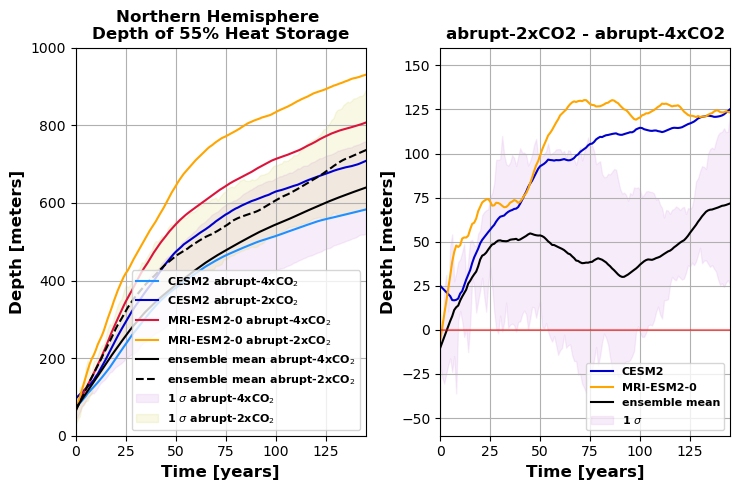

In [454]:
## Table 2d, Supplemental Figure S7b ##

fig1, (ax1, ax2) = plt.subplots(1, 2)

fig1.set_figheight(5)
fig1.set_figwidth(7.5)

legend_properties = {'weight':'bold'}

mean_4x = []
mean_2x = []
mean_4x_noIPSL = []

print('Last 20 Year Depth of 55% Northern Hemisphere Heat Storage \nModel, Abrupt-2x-CO2, Abrupt-4xCO2, Difference')

for i, model in enumerate(model_list):
    if model == 'MIROC6':
        continue
        
    elif model == 'CESM2':
        ax1.plot(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['north']['55'], 11, 1), color='dodgerblue', label='CESM2 abrupt-4xCO$_2$')
        ax1.plot(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['north']['55'], 11, 1), color='mediumblue', label='CESM2 abrupt-2xCO$_2$')
        ax2.plot(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['north']['55'], 11, 1) - signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['north']['55'], 11, 1), label='CESM2', color='mediumblue')
        print(model, np.mean(heat_storage['abrupt-2xCO2'][model]['north']['55'][-20:]), np.mean(heat_storage['abrupt-4xCO2'][model]['north']['55'][-20:]), np.mean(heat_storage['abrupt-2xCO2'][model]['north']['55'][-20:]) - np.mean(heat_storage['abrupt-4xCO2'][model]['north']['55'][-20:]))
        
    elif model == 'MRI-ESM2-0':
        ax1.plot(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['north']['55'], 11, 1), color='crimson', label='MRI-ESM2-0 abrupt-4xCO$_2$')
        ax1.plot(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['north']['55'], 11, 1), color='orange', label='MRI-ESM2-0 abrupt-2xCO$_2$')
        ax2.plot(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['north']['55'], 11, 1) - signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['north']['55'], 11, 1), label='MRI-ESM2-0', color='orange')
        print(model, np.mean(heat_storage['abrupt-2xCO2'][model]['north']['55'][-20:]), np.mean(heat_storage['abrupt-4xCO2'][model]['north']['55'][-20:]), np.mean(heat_storage['abrupt-2xCO2'][model]['north']['55'][-20:]) - np.mean(heat_storage['abrupt-4xCO2'][model]['north']['55'][-20:]))
        
    else: # IPSL-CM6A-LR is missing the abrupt-2xCO2 value
        if model == 'IPSL-CM6A-LR':
            mean_4x.append(heat_storage['abrupt-4xCO2'][model]['north']['55'])
            print(model, '\t \t \t', np.mean(heat_storage['abrupt-4xCO2'][model]['north']['55'][-20:]))
        else:
            mean_4x_noIPSL.append(heat_storage['abrupt-4xCO2'][model]['north']['55'])
            mean_4x.append(heat_storage['abrupt-4xCO2'][model]['north']['55'])
            mean_2x.append(heat_storage['abrupt-2xCO2'][model]['north']['55'])
            print(model, np.mean(heat_storage['abrupt-2xCO2'][model]['north']['55'][-20:]), np.mean(heat_storage['abrupt-4xCO2'][model]['north']['55'][-20:]), np.mean(heat_storage['abrupt-2xCO2'][model]['north']['55'][-20:]) - np.mean(heat_storage['abrupt-4xCO2'][model]['north']['55'][-20:]))

    
mean2x = np.mean(mean_2x, axis=0)
mean4x = np.mean(mean_4x, axis=0)
mean4x_noIPSL = np.mean(mean_4x_noIPSL, axis=0)

std2x = np.std(mean_2x, axis=0)
std4x = np.std(mean_4x, axis=0)

std_diff = np.std(np.array(mean_2x) - np.array(mean_4x_noIPSL), axis=0)
diff   = mean2x - mean4x_noIPSL
    
ax1.plot(signal.savgol_filter(mean4x, 11, 1), color='k', label='ensemble mean abrupt-4xCO$_2$')
ax1.plot(signal.savgol_filter(mean2x, 11, 1), color='k', linestyle='dashed', label='ensemble mean abrupt-2xCO$_2$')
ax2.plot(signal.savgol_filter(diff, 11, 1), color='k', label='ensemble mean')
ax1.fill_between(range(149), mean4x - std4x, mean4x + std4x, color='mediumorchid', alpha=0.1, label='1 $\\sigma$ abrupt-4xCO$_2$')
ax1.fill_between(range(149), mean2x - std2x, mean2x + std2x, color='y', alpha=0.1, label='1 $\\sigma$ abrupt-2xCO$_2$')
ax2.fill_between(range(149), diff - std_diff, diff + std_diff, color='mediumorchid', alpha=0.1, label='1 $\\sigma$')
ax1.grid()
ax2.grid()

ax1.set_xlabel('Time [years]', fontsize=12, fontweight='bold')
ax1.set_ylabel('Depth [meters]', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time [years]', fontsize=12, fontweight='bold')
ax2.set_ylabel('Depth [meters]', fontsize=12, fontweight='bold')
ax1.set_xlim([0, 145])
ax2.set_xlim([0, 145])
ax1.set_ylim([0, 1000])
ax2.set_ylim([-60, 160])
ax2.axhline(y=0, color='r', alpha=0.5)

ax1.set_title('Northern Hemisphere \nDepth of 55% Heat Storage', fontsize=12, fontweight='bold')
ax2.set_title('abrupt-2xCO2 - abrupt-4xCO2', fontsize=12, fontweight='bold')
legend_properties = {'weight':'bold', 'size':8}
ax1.legend(loc='lower right', prop=legend_properties)
ax2.legend(loc='lower right', prop=legend_properties)

plt.tight_layout()

plt.savefig('./Figures/northern_heatstorage_timeseries.png', dpi=300)

slope [1.6816 1.3212 1.053  0.939  0.8342 0.7378 0.6463 0.476 ]
intercept [488.9947 374.7589 292.274  257.6062 226.1606 197.2466 170.9575 123.4403]
p val [0.0036 0.003  0.0023 0.002  0.0018 0.0016 0.0015 0.0016]
r^2 val [0.4916 0.5055 0.523  0.5326 0.5411 0.5485 0.5515 0.5499]


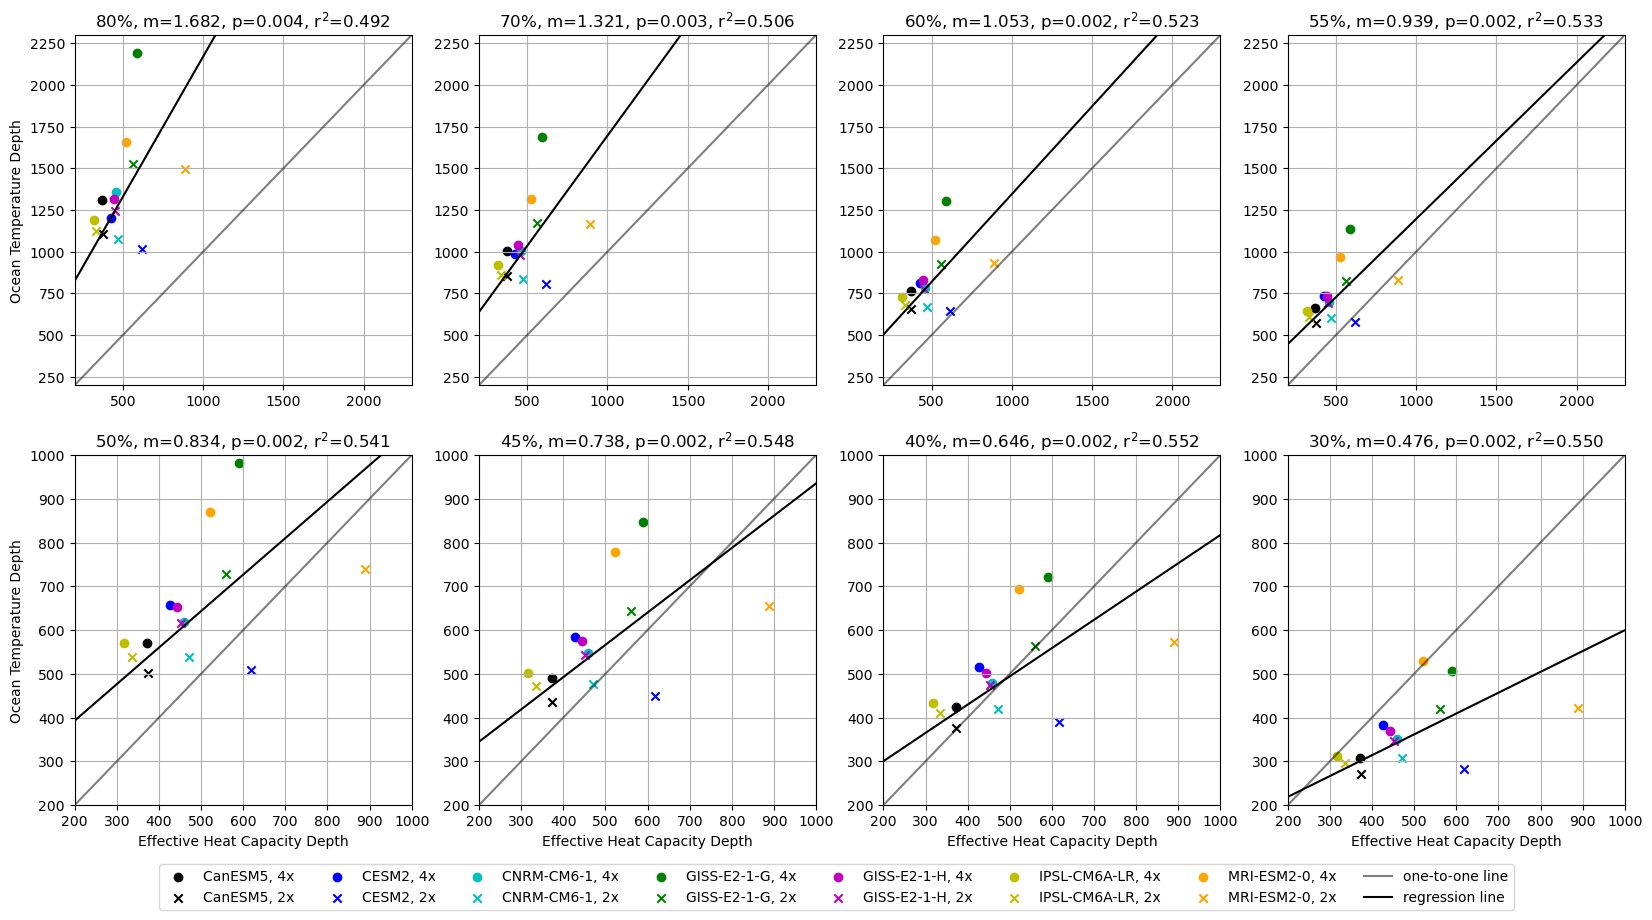

In [455]:
## Supplemental Figure S5 ##

colors = ['k', 'b', 'r', 'c', 'g', 'm', 'y', 'orange']
fig1, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4)

seconds_per_year = 3.154e7
density = 1030 # kg/m^3
c_p     = 4183 # 
conversion = seconds_per_year / density / c_p

fig1.set_figheight(10)
fig1.set_figwidth(20)

points_80 = [0]
points_70 = [0]
points_60 = [0]
points_55 = [0]
points_50 = [0]
points_45 = [0]
points_40 = [0]
points_30 = [0]
x_values  = [0]

start = -5
# which final years to average over
# results robust to final 5, 10, and 20 years

for i, model in enumerate(model_list):
    if model == 'MIROC6':
        continue
        
    p2x_point1 = np.mean(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['80'], 11, 1)[start:])
    p4x_point1 = np.mean(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['80'], 11, 1)[start:])
    
    p2x_point2 = np.mean(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['70'], 11, 1)[start:])
    p4x_point2 = np.mean(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['70'], 11, 1)[start:])
    
    p2x_point3 = np.mean(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['60'], 11, 1)[start:])
    p4x_point3 = np.mean(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['60'], 11, 1)[start:])

    p2x_point4 = np.mean(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['55'], 11, 1)[start:])
    p4x_point4 = np.mean(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['55'], 11, 1)[start:])
    
    p2x_point5 = np.mean(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['50'], 11, 1)[start:])
    p4x_point5 = np.mean(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['50'], 11, 1)[start:])
    
    p2x_point6 = np.mean(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['45'], 11, 1)[start:])
    p4x_point6 = np.mean(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['45'], 11, 1)[start:])
    
    p2x_point7 = np.mean(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['40'], 11, 1)[start:])
    p4x_point7 = np.mean(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['40'], 11, 1)[start:])
    
    p2x_point8 = np.mean(signal.savgol_filter(heat_storage['abrupt-2xCO2'][model]['global']['30'], 11, 1)[start:])
    p4x_point8 = np.mean(signal.savgol_filter(heat_storage['abrupt-4xCO2'][model]['global']['30'], 11, 1)[start:])
    
    points_80.append(p2x_point1)
    points_80.append(p4x_point1)
    
    points_70.append(p2x_point2)
    points_70.append(p4x_point2)
    
    points_60.append(p2x_point3)
    points_60.append(p4x_point3)
    
    points_55.append(p2x_point4)
    points_55.append(p4x_point4)
    
    points_50.append(p2x_point5)
    points_50.append(p4x_point5)
    
    points_45.append(p2x_point6)
    points_45.append(p4x_point6)
    
    points_40.append(p2x_point7)
    points_40.append(p4x_point7)

    points_30.append(p2x_point8)
    points_30.append(p4x_point8)
    
    x_4x = np.mean(heat_capacity_2x[model][start:])*conversion
    x_2x = np.mean(heat_capacity_4x[model][start:])*conversion
    
    x_values.append(x_2x)
    x_values.append(x_4x)
        
    ax1.scatter(x_2x, p2x_point1, label='%s, 4x' % model, marker='o', color=colors[i])
    ax1.scatter(x_4x, p4x_point1, label='%s, 2x' % model, marker='x', color=colors[i])
    
    ax2.scatter(x_2x, p2x_point2, marker='o', color=colors[i])
    ax2.scatter(x_4x, p4x_point2, marker='x', color=colors[i])
    
    ax3.scatter(x_2x, p2x_point3, marker='o', color=colors[i])
    ax3.scatter(x_4x, p4x_point3, marker='x', color=colors[i])
    
    ax4.scatter(x_2x, p2x_point4, marker='o', color=colors[i])
    ax4.scatter(x_4x, p4x_point4, marker='x', color=colors[i])
    
    ax5.scatter(x_2x, p2x_point5, marker='o', color=colors[i])
    ax5.scatter(x_4x, p4x_point5, marker='x', color=colors[i])
    
    ax6.scatter(x_2x, p2x_point6, marker='o', color=colors[i])
    ax6.scatter(x_4x, p4x_point6, marker='x', color=colors[i])
    
    ax7.scatter(x_2x, p2x_point7, marker='o', color=colors[i])
    ax7.scatter(x_4x, p4x_point7, marker='x', color=colors[i])
    
    ax8.scatter(x_2x, p2x_point8, marker='o', color=colors[i])
    ax8.scatter(x_4x, p4x_point8, marker='x', color=colors[i])
    
    ax1.set_xlim(200, 2300)
    ax2.set_xlim(200, 2300)
    ax3.set_xlim(200, 2300)
    ax4.set_xlim(200, 2300)
    ax5.set_xlim(200, 1000)
    ax6.set_xlim(200, 1000)
    ax7.set_xlim(200, 1000)
    ax8.set_xlim(200, 1000)
    
    ax1.set_ylim(200, 2300)
    ax2.set_ylim(200, 2300)
    ax3.set_ylim(200, 2300)
    ax4.set_ylim(200, 2300)
    ax5.set_ylim(200, 1000)
    ax6.set_ylim(200, 1000)
    ax7.set_ylim(200, 1000)
    ax8.set_ylim(200, 1000)

    ax5.set_xlabel('Effective Heat Capacity Depth')
    ax6.set_xlabel('Effective Heat Capacity Depth')
    ax7.set_xlabel('Effective Heat Capacity Depth')
    ax8.set_xlabel('Effective Heat Capacity Depth')
    
    ax1.set_ylabel('Ocean Temperature Depth')
    ax5.set_ylabel('Ocean Temperature Depth')
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()
    ax7.grid()
    ax8.grid()
    
m1, c1, r1, p1, s1 = stats.linregress(x_values, points_80)
m2, c2, r2, p2, s2 = stats.linregress(x_values, points_70)
m3, c3, r3, p3, s3 = stats.linregress(x_values, points_60)
m4, c4, r4, p4, s4 = stats.linregress(x_values, points_55)
m5, c5, r5, p5, s5 = stats.linregress(x_values, points_50)
m6, c6, r6, p6, s6 = stats.linregress(x_values, points_45)
m7, c7, r7, p7, s7 = stats.linregress(x_values, points_40)
m8, c8, r8, p8, s8 = stats.linregress(x_values, points_30)

np.set_printoptions(precision=4)
print('slope', np.array([m1, m2, m3, m4, m5, m6, m7, m8]))
print('intercept', np.array([c1, c2, c3, c4, c5, c6, c7, c8]))
print('p val', np.array([p1, p2, p3, p4, p5, p6, p7, p8]))
print('r^2 val', np.array([r1**2, r2**2, r3**2, r4**2, r5**2, r6**2, r7**2, r8**2]))

ax1.set_title('80%%, m=%.3f, p=%.3f, r$^2$=%.3f' % (m1, p1, r1**2))
ax2.set_title('70%%, m=%.3f, p=%.3f, r$^2$=%.3f' % (m2, p2, r2**2))
ax3.set_title('60%%, m=%.3f, p=%.3f, r$^2$=%.3f' % (m3, p3, r3**2))
ax4.set_title('55%%, m=%.3f, p=%.3f, r$^2$=%.3f' % (m4, p4, r4**2))
ax5.set_title('50%%, m=%.3f, p=%.3f, r$^2$=%.3f' % (m5, p5, r5**2))
ax6.set_title('45%%, m=%.3f, p=%.3f, r$^2$=%.3f' % (m6, p6, r6**2))
ax7.set_title('40%%, m=%.3f, p=%.3f, r$^2$=%.3f' % (m7, p7, r7**2))
ax8.set_title('30%%, m=%.3f, p=%.3f, r$^2$=%.3f' % (m8, p8, r8**2))

ax1.plot(np.arange(200, 2500, 50), np.arange(200, 2500, 50), color='k', alpha=0.5, label='one-to-one line')
ax1.plot(np.arange(200, 2500, 50), m1*np.arange(200, 2500, 50)+c1, color='k', label='regression line')

ax2.plot(np.arange(200, 2500, 50), np.arange(200, 2500, 50), color='k', alpha=0.5)
ax2.plot(np.arange(200, 2500, 50), m2*np.arange(200, 2500, 50)+c2, color='k')

ax3.plot(np.arange(200, 2500, 50), np.arange(200, 2500, 50), color='k', alpha=0.5)
ax3.plot(np.arange(200, 2500, 50), m3*np.arange(200, 2500, 50)+c3, color='k')

ax4.plot(np.arange(200, 2500, 50), np.arange(200, 2500, 50), color='k', alpha=0.5)
ax4.plot(np.arange(200, 2500, 50), m4*np.arange(200, 2500, 50)+c4, color='k')

ax5.plot(np.arange(200, 1200, 50), np.arange(200, 1200, 50), color='k', alpha=0.5)
ax5.plot(np.arange(200, 1200, 50), m5*np.arange(200, 1200, 50)+c5, color='k')

ax6.plot(np.arange(200, 1200, 50), np.arange(200, 1200, 50), color='k', alpha=0.5)
ax6.plot(np.arange(200, 1200, 50), m6*np.arange(200, 1200, 50)+c6, color='k')

ax7.plot(np.arange(200, 1200, 50), np.arange(200, 1200, 50), color='k', alpha=0.5)
ax7.plot(np.arange(200, 1200, 50), m7*np.arange(200, 1200, 50)+c7, color='k')

ax8.plot(np.arange(200, 1200, 50), np.arange(200, 1200, 50), color='k', alpha=0.5)
ax8.plot(np.arange(200, 1200, 50), m8*np.arange(200, 1200, 50)+c8, color='k')

ax1.legend(loc=(0.25, -1.5), ncol=8)

plt.savefig('./Figures/heatstorage_heatcapacity_scatter.png', dpi=300)

model, NH 2x, NH 4x, SH 2x, SH 4x
CanESM5 1.2063334848462952 1.0411823209342197 0.7936665151536934 0.9588176790657774
CESM2 0.40358684274319245 0.8214829692335429 1.5964131572568103 1.1785170307664574
MIROC6 1.1884857888797904 1.2360702408032782 0.8115142111202047 0.7639297591967268
CNRM-CM6-1 0.9033523152409934 0.8818038400425149 1.096647684758991 1.1181961599574919
GISS-E2-1-G 1.2232832517088974 0.6826982148112197 0.7767167482910813 1.3173017851888174
GISS-E2-1-H 0.967938167453018 0.9325315221672466 1.0320618325469795 1.0674684778327475
IPSL-CM6A-LR 1.2280813243605404 1.056938254917592 0.7687127025599583 0.9422578558029493
MRI-ESM2-0 0.5969893469237195 0.7260095495325799 1.4030106530762587 1.2739904504674253


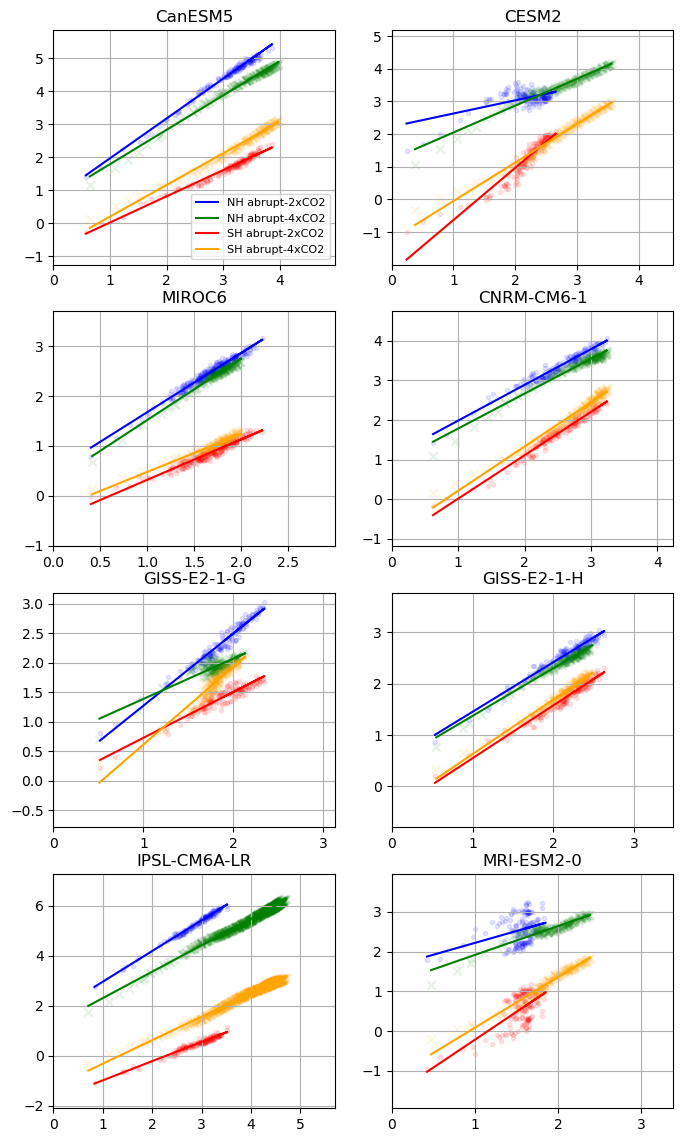

In [456]:
## Temperature Pattern, Supplemental Table S4 ##

# As in, the regression of local warming to global mean warming
# here, we've regressed the mean hemisphere (northern and southern) tas against the mean global tas
# slope = 1 means the hemisphere warms at the same rate as the global
# slope > 1 means the hemisphere warms more quickly than globally
# slope < 1 means the hemisphere warms more slowly than globally

fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

fig1.set_figheight(14)
fig1.set_figwidth(8)

print('model, NH 2x, NH 4x, SH 2x, SH 4x')
for i, model in enumerate(model_list):
    ax = axs[i]
    ax.grid()
    
    lat_vals = temperature['abrupt-4xCO2'][model]['lat']
    lon_vals = np.array(temperature['abrupt-4xCO2'][model].columns[1:], dtype=float)
    
    gm_temp2 =  data['abrupt-2xCO2'][model]['tas'] - data_pi['tas'][model]
    gm_temp4 = (data['abrupt-4xCO2'][model]['tas'] - data_pi['tas'][model])*normalize
    
    nh_temp2 =  data['abrupt-2xCO2'][model]['tas-nh'] - data_pi['tas'][model]
    nh_temp4 = (data['abrupt-4xCO2'][model]['tas-nh'] - data_pi['tas'][model])*normalize
    
    sh_temp2 =  data['abrupt-2xCO2'][model]['tas-sh'] - data_pi['tas'][model]
    sh_temp4 = (data['abrupt-4xCO2'][model]['tas-sh'] - data_pi['tas'][model])*normalize
    
    m1, b1, r1, p1, se1 = stats.linregress(gm_temp2, nh_temp2)
    m2, b2, r2, p2, se2 = stats.linregress(gm_temp4, nh_temp4)
    m3, b3, r3, p3, se3 = stats.linregress(gm_temp2, sh_temp2)
    m4, b4, r4, p4, se4 = stats.linregress(gm_temp4, sh_temp4)
    
    ax.scatter(gm_temp2, nh_temp2, marker='.', color='b', alpha=0.1)
    ax.plot(gm_temp2, m1*gm_temp2+b1, color='b', label='NH abrupt-2xCO2')
    
    ax.scatter(gm_temp4, nh_temp4, marker='x', color='g', alpha=0.1)
    ax.plot(gm_temp4, m2*gm_temp4+b2, color='g', label='NH abrupt-4xCO2')
    
    ax.scatter(gm_temp2, sh_temp2, marker='.', color='r', alpha=0.1)
    ax.plot(gm_temp2, m3*gm_temp2+b3, color='r', label='SH abrupt-2xCO2')
    
    ax.scatter(gm_temp4, sh_temp4, marker='x', color='orange', alpha=0.1)
    ax.plot(gm_temp4, m4*gm_temp4+b4, color='orange', label='SH abrupt-4xCO2')
    
    print(model, m1, m2, m3, m4)
    
    ax.set_xlim(0, max(gm_temp4)+1)
    ax.set_ylim(min(sh_temp2)-1, max(nh_temp4)+1)
    
    ax.set_title(model)

legend_properties = {'size':8}
ax1.legend(loc='lower right', ncol=1, prop=legend_properties)

plt.savefig('./Figures/temperature_regression_ensemble.png', dpi=300)

# Zonal Figures

/home/disk/p/apolet/anaconda3/envs/dask_env/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


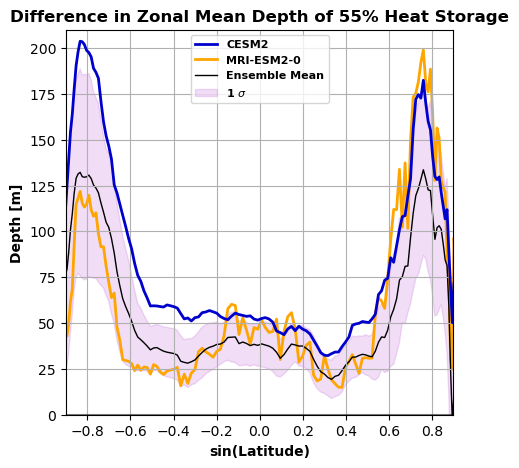

In [457]:
## Figure 1e ##

mean_list = []
fig1 = plt.figure()
fig1.set_figheight(5)
fig1.set_figwidth(5)
plt.ylim(0, 210)
plt.xlim(-0.9, 0.9)
plt.axhline(y=0, color='black', alpha=0.5)
plt.grid()

legend_properties = {'weight':'bold'}

plt.xlabel('sin(Latitude)',  fontweight='bold')
plt.ylabel('Depth [m]',  fontweight='bold')
        
colors = ['k', 'mediumblue', 'b', 'g', 'm', 'y', 'c', 'orange']

for i, model in enumerate(model_list):
    if (model == 'CESM2') or (model == 'MRI-ESM2-0'):
        if model == 'CESM2':
            z = 2
            a = 1
        else:
            z = 1
            a = 1
        
        x_value = np.sin(np.deg2rad(lats[model]))
        plt.plot(x_value, zonal_storage['abrupt-2xCO2'][model]['55']-zonal_storage['abrupt-4xCO2'][model]['55'], label=model, color=colors[i], linewidth=2, zorder=z, alpha=a)
        plt.title('Difference in Zonal Mean Depth of 55% Heat Storage', fontsize=12, fontweight='bold')
    
    if model == 'MIROC6':
        continue
        
    else:
        mean_list.append(zonal_storage['abrupt-2xCO2'][model]['55']-zonal_storage['abrupt-4xCO2'][model]['55'])
        
ensemble_mean = np.mean(np.array(mean_list), axis=0)
ensemble_std  = np.std(np.array(mean_list), axis=0)

plt.plot(x_value, ensemble_mean, label='Ensemble Mean', color='k', zorder=1, linewidth=1)
plt.fill_between(x_value, ensemble_mean - ensemble_std, ensemble_mean + ensemble_std, alpha=0.2, color='mediumorchid', zorder=0, label='1 $\\sigma$')
legend_properties = {'weight':'bold', 'size':8}
plt.legend(loc='upper center', ncol=1, prop=legend_properties)

plt.savefig('./Figures/heatstorage_zonal.png', dpi=300)

# Map Figures

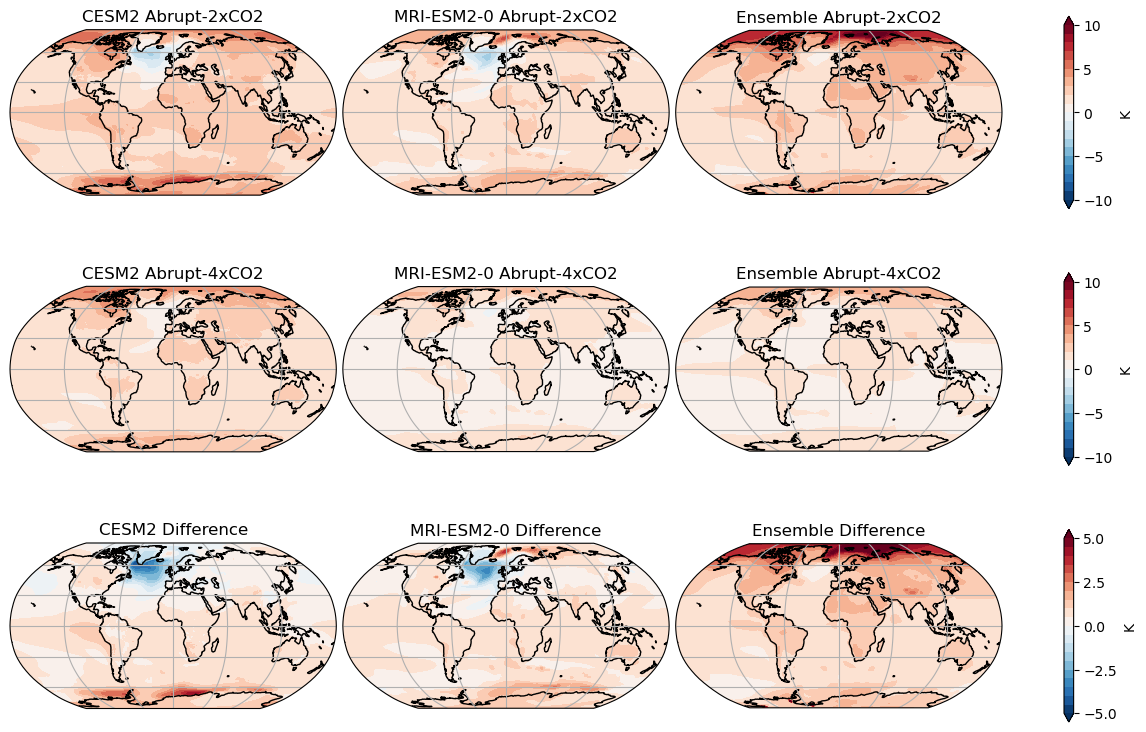

In [59]:
## Figure 2a ##
## Mean over years 1 to 150

levels_tas  = np.linspace(-10, 10, 21)
levels_diff = np.linspace(-5, 5, 21)

fig1 = plt.figure(figsize=(16, 10))
#fig1.suptitle('Surface Temperature Anomaly' , fontsize=16)
fig1.subplots_adjust(wspace=0.02, hspace=0)

temp_4x_sum = np.ones((64, 128, 6))
temp_2x_sum = np.ones((64, 128, 6))
j = 0

for i, model in enumerate(model_list):

    if model == "CESM2":
        lat_vals = temperature['abrupt-4xCO2'][model]['lat']
        lon_vals = np.array(temperature['abrupt-4xCO2'][model].columns[1:], dtype=float)
        
        temp_4x = temperature['abrupt-4xCO2'][model][:].values[:, 1:] * normalize_model[model]
        temp_2x = temperature['abrupt-2xCO2'][model][:].values[:, 1:]
        
        temp_4x, lon_vals2 = cutil.add_cyclic_point(temp_4x, lon_vals)
        temp_2x, lon_vals2 = cutil.add_cyclic_point(temp_2x, lon_vals)

        ax_1 = fig1.add_subplot(3, 3, 1, projection = ccrs.Robinson(central_longitude=0))
        pcm1 = ax_1.contourf(lon_vals2, lat_vals, temp_2x, levels = levels_tas, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree())
        ax_1.coastlines()
        ax_1.gridlines()
        ax_1.set_title('%s Abrupt-2xCO2' % model)
        
        ax_4 = fig1.add_subplot(3, 3, 4, projection = ccrs.Robinson(central_longitude=0))
        pcm4 = ax_4.contourf(lon_vals2, lat_vals, temp_4x, levels = levels_tas, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree())
        ax_4.coastlines()
        ax_4.gridlines()
        ax_4.set_title('%s Abrupt-4xCO2' % model)
        
        ax_7 = fig1.add_subplot(3, 3, 7, projection = ccrs.Robinson(central_longitude=0))
        pcm7 = ax_7.contourf(lon_vals2, lat_vals, temp_2x - temp_4x, levels = levels_diff, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree())
        ax_7.coastlines()
        ax_7.gridlines()
        ax_7.set_title('%s Difference' % model)
        
    elif model == "MRI-ESM2-0":
        lat_vals = temperature['abrupt-4xCO2'][model]['lat']
        lon_vals = np.array(temperature['abrupt-4xCO2'][model].columns[1:], dtype=float)
        
        temp_4x = temperature['abrupt-4xCO2'][model][:].values[:, 1:] * normalize_model[model]
        temp_2x = temperature['abrupt-2xCO2'][model][:].values[:, 1:]
        
        temp_4x, lon_vals2 = cutil.add_cyclic_point(temp_4x, lon_vals)
        temp_2x, lon_vals2 = cutil.add_cyclic_point(temp_2x, lon_vals)

        ax_2 = fig1.add_subplot(3, 3, 2, projection = ccrs.Robinson(central_longitude=0))
        pcm2 = ax_2.contourf(lon_vals2, lat_vals, temp_2x, levels = levels_tas, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree())
        ax_2.coastlines()
        ax_2.gridlines()
        ax_2.set_title('%s Abrupt-2xCO2' % model)
        
        ax_5 = fig1.add_subplot(3, 3, 5, projection = ccrs.Robinson(central_longitude=0))
        pcm5 = ax_5.contourf(lon_vals2, lat_vals, temp_4x, levels = levels_tas, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree())
        ax_5.coastlines()
        ax_5.gridlines()
        ax_5.set_title('%s Abrupt-4xCO2' % model)

        ax_8 = fig1.add_subplot(3, 3, 8, projection = ccrs.Robinson(central_longitude=0))
        pcm8 = ax_8.contourf(lon_vals2, lat_vals, temp_2x - temp_4x, levels = levels_diff, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree())
        ax_8.coastlines()
        ax_8.gridlines()
        ax_8.set_title('%s Difference' % model)
    
    elif model not in ['CESM2', 'MRI-ESM2-0']:
        # all models beside CESM2 and MRI-ESM2-0 were interpolated to the CanESM5 grid and will be averaged for the ensemble
        interp_lats = temperature['abrupt-4xCO2'][model]['lat']
        interp_lons = np.array(temperature['abrupt-4xCO2'][model].columns[1:], dtype=float)
        
        temp_4x_sum[:, :, j] = temperature['abrupt-4xCO2'][model][:].values[:, 1:] * normalize_model[model]
        temp_2x_sum[:, :, j] = temperature['abrupt-2xCO2'][model][:].values[:, 1:]
        j += 1

temp_4x_mean = np.mean(temp_4x_sum, axis=2)
temp_2x_mean = np.mean(temp_2x_sum, axis=2)

temp_4x_mean, lon2 = cutil.add_cyclic_point(temp_4x_mean, interp_lons)
temp_2x_mean, lon2 = cutil.add_cyclic_point(temp_2x_mean, interp_lons)

# Plot Ensemble Average
ax_3 = fig1.add_subplot(3, 3, 3, projection = ccrs.Robinson(central_longitude=0))
pcm3 = ax_3.contourf(lon2, interp_lats, temp_2x_mean, levels = levels_tas, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree())
ax_3.coastlines()
ax_3.gridlines()
ax_3.set_title('Ensemble Abrupt-2xCO2')

ax_6 = fig1.add_subplot(3, 3, 6, projection = ccrs.Robinson(central_longitude=0))
pcm6 = ax_6.contourf(lon2, interp_lats, temp_4x_mean, levels = levels_tas, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree())
ax_6.coastlines()
ax_6.gridlines()
ax_6.set_title('Ensemble Abrupt-4xCO2')
    
ax_9 = fig1.add_subplot(3, 3, 9, projection = ccrs.Robinson(central_longitude=0))
pcm9 = ax_9.contourf(lon2, interp_lats, temp_2x_mean - temp_4x_mean, levels = levels_diff, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree())
ax_9.coastlines()
ax_9.gridlines()
ax_9.set_title('Ensemble Difference')

fig1.colorbar(pcm1, ax=[ax_1, ax_2, ax_3], label='K', location='right', shrink=0.75, ticks=[-10, -5, 0, 5, 10])
fig1.colorbar(pcm1, ax=[ax_4, ax_5, ax_6], label='K', location='right', shrink=0.75, ticks=[-10, -5, 0, 5, 10])
fig1.colorbar(pcm9, ax=[ax_7, ax_8, ax_9], label='K', location='right', shrink=0.75, ticks=[-5, -2.5, 0, 2.5, 5])

#axs1[0].set_ylabel('Latitude')
#axs1[1].set_ylabel('Latitude')
#axs1[2].set_ylabel('Latitude')

#for ax in axs1:
#    ax.set_xlabel('Longitude')
    
#plt.savefig("./Figures/temp_ensemble.png", dpi=300)

/tmp/ipykernel_2578611/2888595381.py:30: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p2.axes.flat:
/tmp/ipykernel_2578611/2888595381.py:45: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p2.axes.flat:
/tmp/ipykernel_2578611/2888595381.py:64: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p2.axes.flat:
/tmp/ipykernel_2578611/2888595381.py:81: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p2.axes.flat:


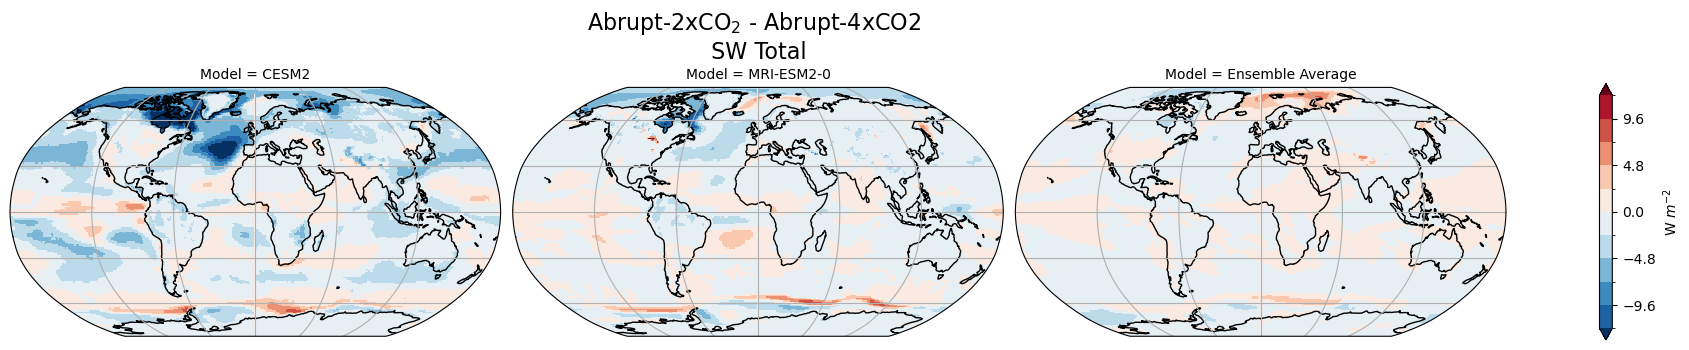

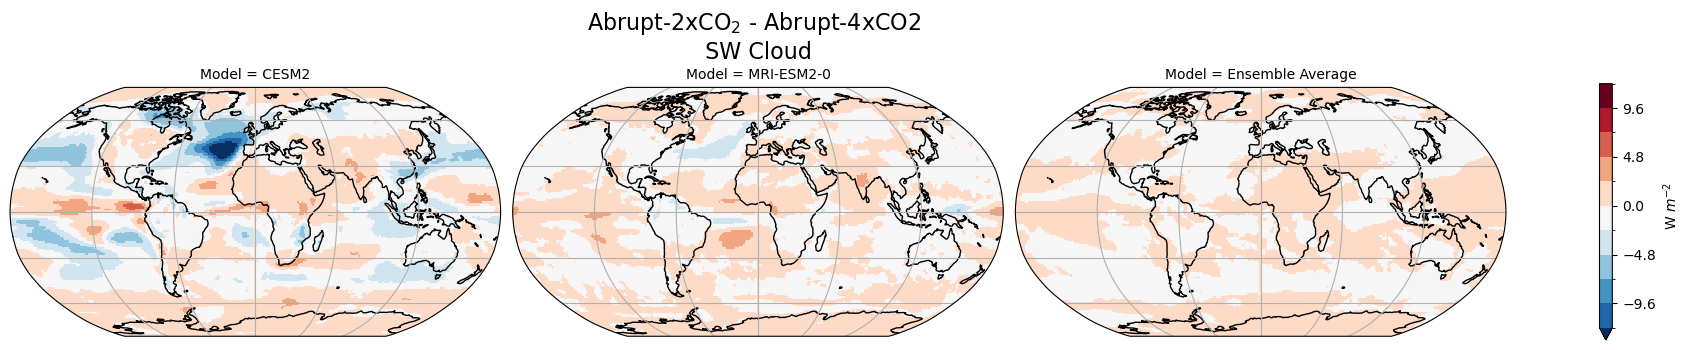

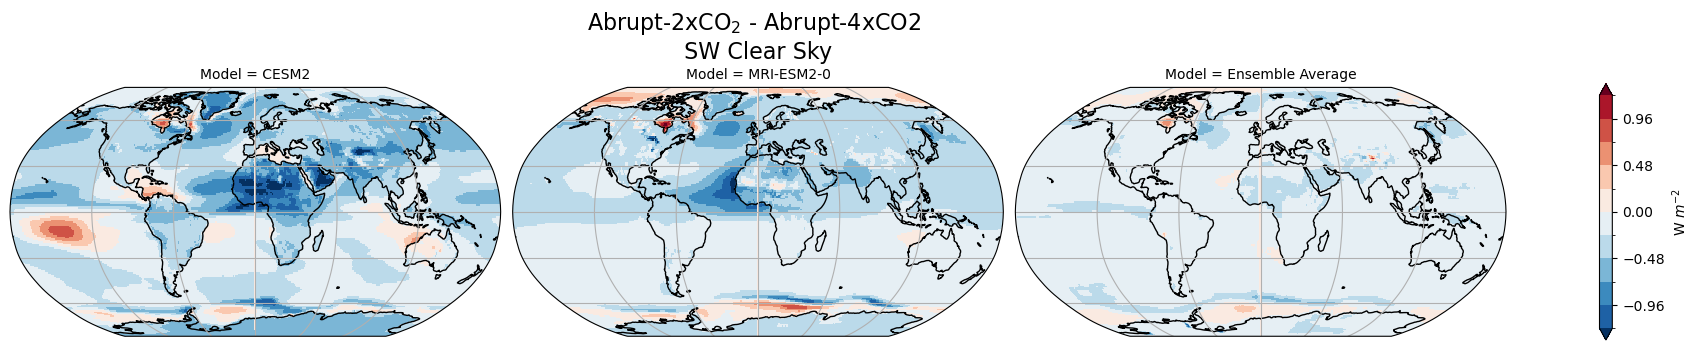

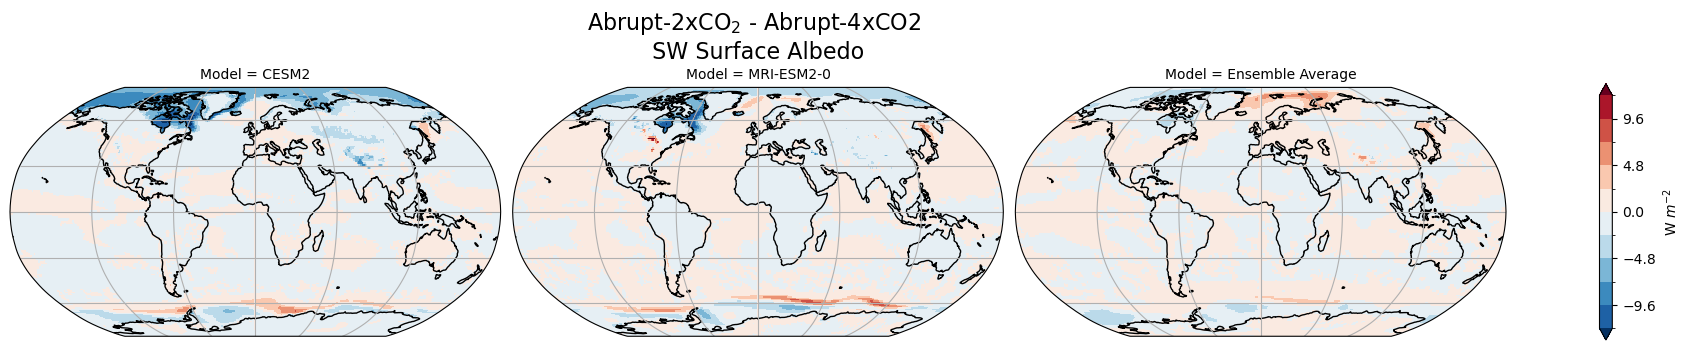

In [16]:
## Figure 2c & Supplemental Figure S3 ##
## Calculated over Years 1 to 150

#ensemble
plotds_ensemble = aprp_map_2x_ensemble.mean('Model').mean(dim='month') - aprp_map_4x_ensemble.mean('Model').mean(dim='month')

# CESM2, MRI-ESM2-0
plotds_models = aprp_map_2x_models.mean(dim='month') - aprp_map_4x_models.mean(dim='month')

# rename "Ensemble Average"
plotds_ensemble = plotds_ensemble.assign_coords(Model = "Ensemble Average")

# Combine
plotds_5 = xr.concat([plotds_models, plotds_ensemble], dim="Model")

# Figures #

# SW Total
p2 = plotds_5.total.plot(transform = ccrs.PlateCarree(), 
                         col = "Model", #row = 'Period', 
                         robust = True, cmap = 'RdBu_r', 
                         aspect = plotds_2.dims["lon"]/plotds_2.dims["lat"],
                         col_wrap=3, center=0, vmin=-12, vmax=12, levels=11,
                         subplot_kws = {"projection": map_proj}, 
                         cbar_kwargs = {"label": 'W $m^{-2}$'})

plt.suptitle('Abrupt-2xCO$_2$ - Abrupt-4xCO2 \n SW Total', fontsize=16, y=1.15, x=0.4) #Big title at top

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()

# SW Cloud
p2 = plotds_5.cld.plot(transform = ccrs.PlateCarree(), 
                         col = "Model", #row = 'Period', 
                         robust = True, cmap = 'RdBu_r',
                         aspect = plotds_2.dims["lon"]/plotds_2.dims["lat"],
                         col_wrap=3, center=0, vmin=-12, vmax=12, levels=11,
                         subplot_kws = {"projection": map_proj}, 
                         cbar_kwargs = {"label": 'W $m^{-2}$'})

plt.suptitle('Abrupt-2xCO$_2$ - Abrupt-4xCO2 \n SW Cloud', fontsize=16, y=1.15, x=0.4) #Big title at top

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
# SW Clear Sky
p2 = plotds_5.noncld.plot(transform = ccrs.PlateCarree(), 
                         col = "Model", #row = 'Period', 
                         robust = True, cmap = 'RdBu_r', 
                         aspect = plotds_2.dims["lon"]/plotds_2.dims["lat"],
                         col_wrap=3, center=0, vmin=-1.2, vmax=1.2, levels=11,
                         subplot_kws = {"projection": map_proj}, 
                         cbar_kwargs = {"label": 'W $m^{-2}$'})

# We have to set the map's options on all axes

plt.suptitle('Abrupt-2xCO$_2$ - Abrupt-4xCO2 \n SW Clear Sky', fontsize=16, y=1.15, x=0.4) #Big title at top

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
    
# SW Albedo
p2 = plotds_5.sfc_alb.plot(transform = ccrs.PlateCarree(), 
                         col = "Model", #row = 'Period', 
                         robust = True, cmap = 'RdBu_r',
                         aspect = plotds_2.dims["lon"]/plotds_2.dims["lat"],
                         col_wrap=3, center=0, vmin=-12, vmax=12, levels=11,
                         subplot_kws = {"projection": map_proj}, 
                         cbar_kwargs = {"label": 'W $m^{-2}$'})

# We have to set the map's options on all axes

plt.suptitle('Abrupt-2xCO$_2$ - Abrupt-4xCO2 \n SW Surface Albedo', fontsize=16, y=1.15, x=0.4) #Big title at top

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
    
#plt.savefig('./Figures/APRP_map.png', dpi=300)

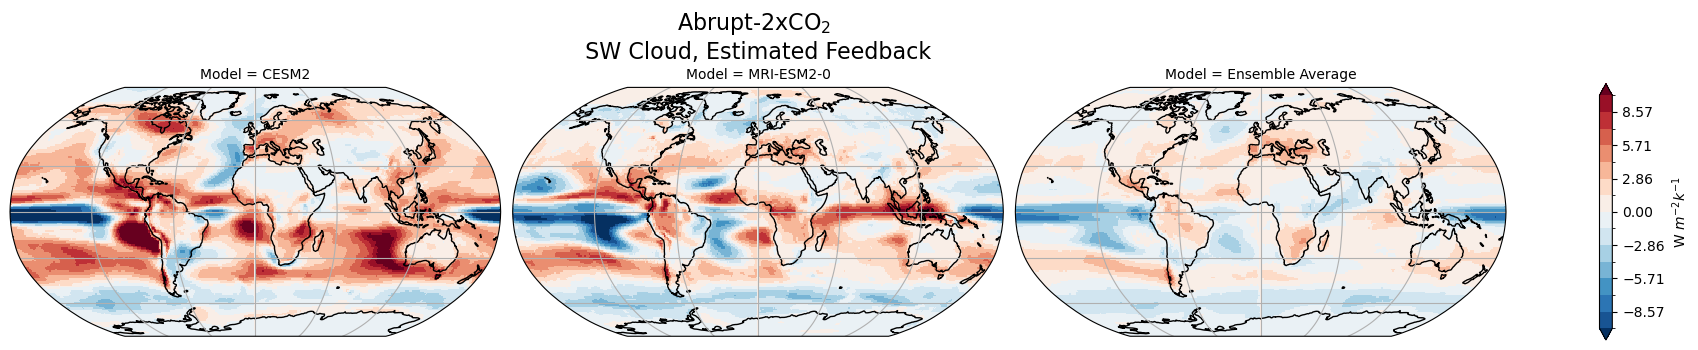

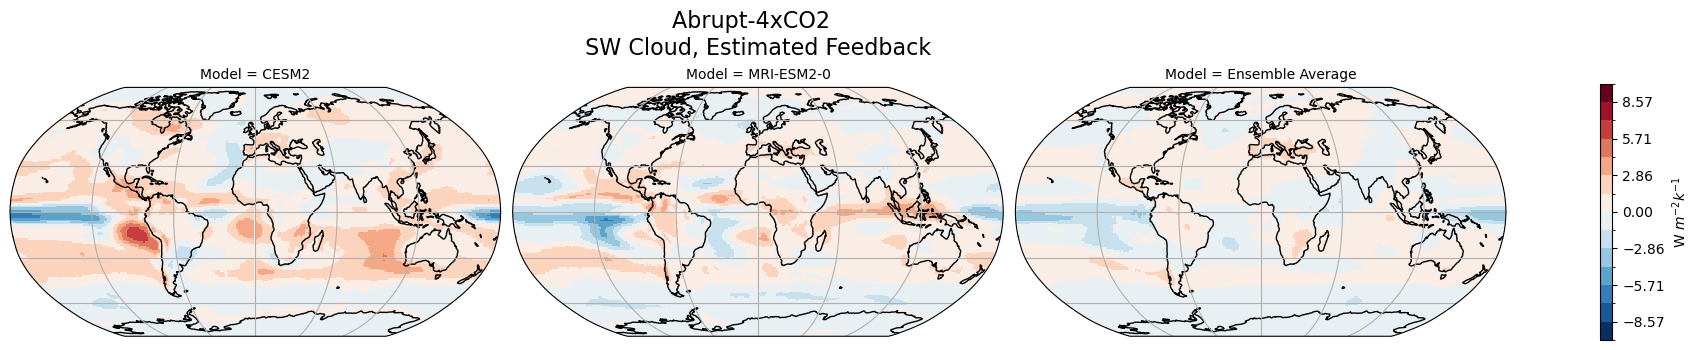

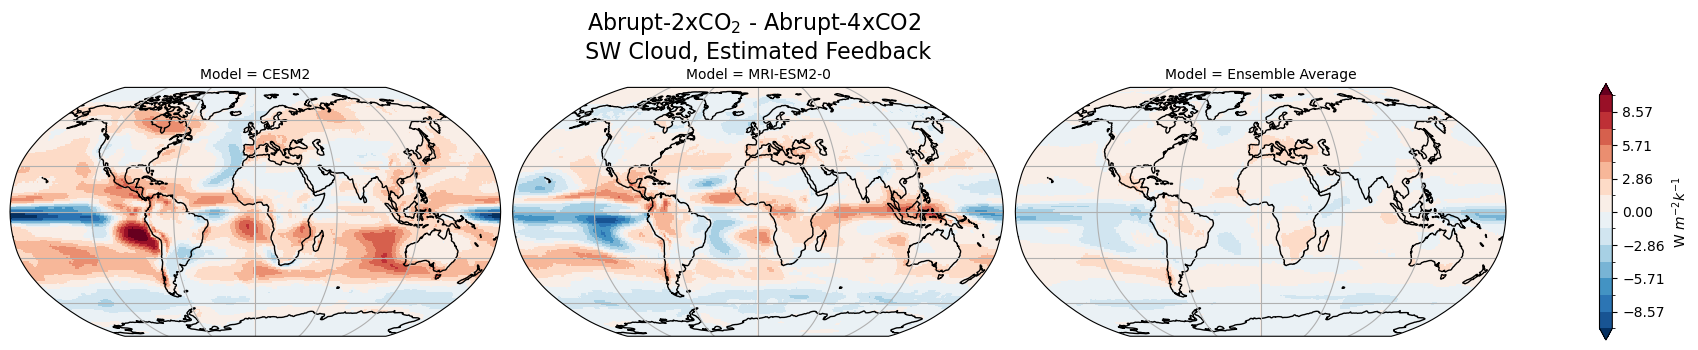

In [75]:
## Figure 2c & Supplemental Figure S3 ##
## Calculated over Years 1 to 150

#ensemble
plotds_ensemble_2x = aprp_feedback_2x_ensemble.mean('Model').mean(dim='month') 
plotds_ensemble_4x = aprp_feedback_4x_ensemble.mean('Model').mean(dim='month') 

# CESM2, MRI-ESM2-0
plotds_models_2x = aprp_feedback_2x_models.mean(dim='month') 
plotds_models_4x = aprp_feedback_4x_models.mean(dim='month') 

# rename "Ensemble Average"
plotds_ensemble_2x = plotds_ensemble_2x.assign_coords(Model = "Ensemble Average")
plotds_ensemble_4x = plotds_ensemble_4x.assign_coords(Model = "Ensemble Average")

# Combine
plotds_2x = xr.concat([plotds_models_2x, plotds_ensemble_2x], dim="Model")
plotds_4x = xr.concat([plotds_models_4x, plotds_ensemble_4x], dim="Model")
plotds_difference = plotds_2x - plotds_4x

# Figures #


# SW Cloud
p2 = plotds_2x.cld.plot(transform = ccrs.PlateCarree(), 
                         col = "Model", #row = 'Period', 
                         robust = True, cmap = 'RdBu_r',
                         aspect = plotds_5.dims["lon"]/plotds_5.dims["lat"],
                         col_wrap=3, center=0, vmin=-10, vmax=10, levels=15,
                         subplot_kws = {"projection": map_proj}, 
                         cbar_kwargs = {"label": 'W $m^{-2}k^{-1}$'})

plt.suptitle('Abrupt-2xCO$_2$ \n SW Cloud, Estimated Feedback', fontsize=16, y=1.15, x=0.4) #Big title at top

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
p2 = plotds_4x.cld.plot(transform = ccrs.PlateCarree(), 
                         col = "Model", #row = 'Period', 
                         robust = True, cmap = 'RdBu_r',
                         aspect = plotds_5.dims["lon"]/plotds_5.dims["lat"],
                         col_wrap=3, center=0, vmin=-10, vmax=10, levels=15,
                         subplot_kws = {"projection": map_proj}, 
                         cbar_kwargs = {"label": 'W $m^{-2}k^{-1}$'})

plt.suptitle('Abrupt-4xCO2 \n SW Cloud, Estimated Feedback', fontsize=16, y=1.15, x=0.4) #Big title at top

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
p2 = plotds_difference.cld.plot(transform = ccrs.PlateCarree(), 
                         col = "Model", #row = 'Period', 
                         robust = True, cmap = 'RdBu_r',
                         aspect = plotds_5.dims["lon"]/plotds_5.dims["lat"],
                         col_wrap=3, center=0, vmin=-10, vmax=10, levels=15,
                         subplot_kws = {"projection": map_proj}, 
                         cbar_kwargs = {"label": 'W $m^{-2}k^{-1}$'})

plt.suptitle('Abrupt-2xCO$_2$ - Abrupt-4xCO2 \n SW Cloud, Estimated Feedback', fontsize=16, y=1.15, x=0.4) #Big title at top

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    
#plt.savefig('./Figures/APRP_map.png', dpi=300)

/tmp/ipykernel_2578611/2978976884.py:60: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p2.axes.flat:
/tmp/ipykernel_2578611/2978976884.py:77: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p2.axes.flat:
/tmp/ipykernel_2578611/2978976884.py:94: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p2.axes.flat:


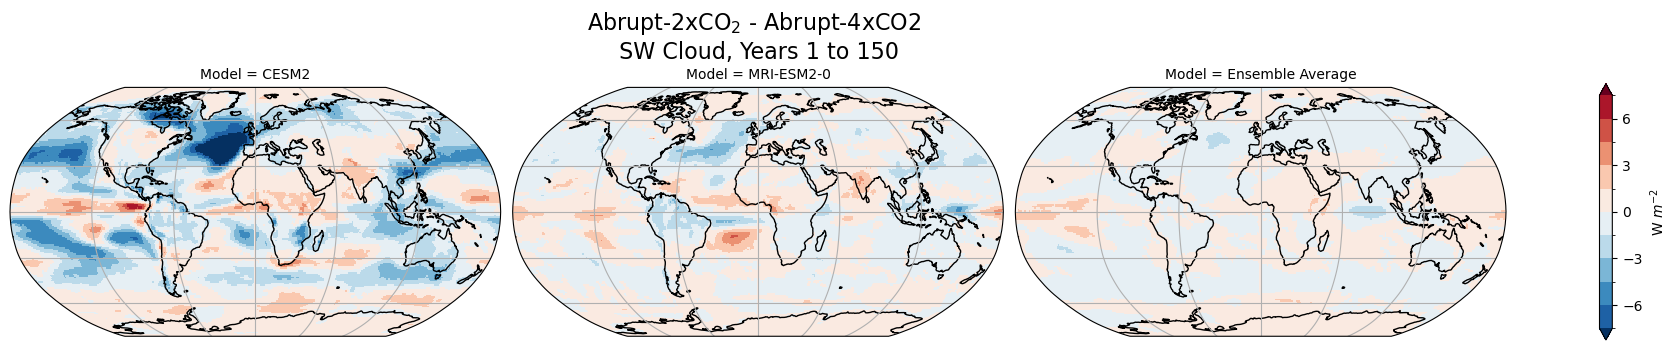

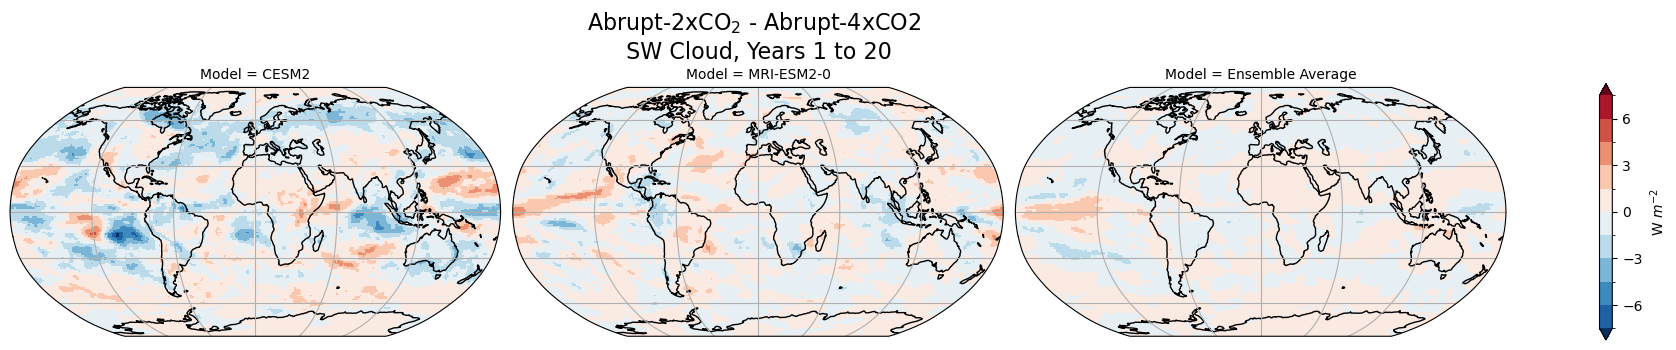

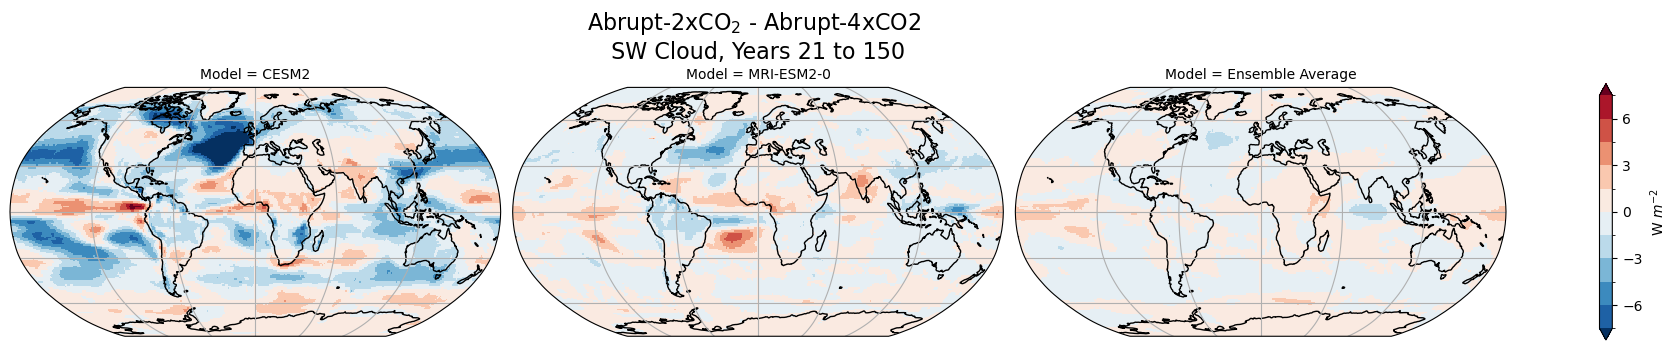

In [23]:
## Figure 2c & Supplemental Figure S3 ##

percor = ['1850-1870','1871-2000'] 

# Years 1 to 150 #

#ensemble
plotds_ensemble = aprp_map_2x_ensemble.mean('Model').mean(dim='month') - aprp_map_4x_ensemble.mean('Model').mean(dim='month')

# CESM2, MRI-ESM2-0
plotds_models = aprp_map_2x_models.mean(dim='month') - aprp_map_4x_models.mean(dim='month')

# rename "Ensemble Average"
plotds_ensemble = plotds_ensemble.assign_coords(Model = "Ensemble Average")

# Combine
plotds_total = xr.concat([plotds_models, plotds_ensemble], dim="Model")

# Years 21 to 150 #

#ensemble
plotds_ensemble_slow = aprp_map_2x_p_ensemble.mean('Model').mean(dim='month').sel(Period=percor[1]) - (aprp_map_4x_p_ensemble.mean('Model').mean(dim='month').sel(Period=percor[1]))

# CESM2, MRI-ESM2-0
plotds_models_slow = aprp_map_2x_p_models.mean(dim='month').sel(Period=percor[1]) - (aprp_map_4x_p_models.mean(dim='month').sel(Period=percor[1]))

# rename "Ensemble Average"
plotds_ensemble_slow = plotds_ensemble_slow.assign_coords(Model = "Ensemble Average")

# Combine
plotds_total_slow = xr.concat([plotds_models_slow, plotds_ensemble_slow], dim="Model")

# Years 1 to 20 #

#ensemble
plotds_ensemble_fast = aprp_map_2x_p_ensemble.mean('Model').mean(dim='month').sel(Period=percor[0]) - (aprp_map_4x_p_ensemble.mean('Model').mean(dim='month').sel(Period=percor[0]))

# CESM2, MRI-ESM2-0
plotds_models_fast = aprp_map_2x_p_models.mean(dim='month').sel(Period=percor[0]) - (aprp_map_4x_p_models.mean(dim='month').sel(Period=percor[0]))

# rename "Ensemble Average"
plotds_ensemble_fast = plotds_ensemble_fast.assign_coords(Model = "Ensemble Average")

# Combine
plotds_total_fast = xr.concat([plotds_models_fast, plotds_ensemble_fast], dim="Model")

# Figures #

# 1 to 150
p2 = plotds_total.cld.plot(transform = ccrs.PlateCarree(), 
                           col = "Model", #row = 'Period', 
                           robust = True, cmap = 'RdBu_r', extend='both',
                           aspect = plotds_2.dims["lon"]/plotds_2.dims["lat"],
                           col_wrap=3, center=0, vmin=-7.5, vmax=7.5, levels=11,
                           subplot_kws = {"projection": map_proj}, 
                           cbar_kwargs = {"label": 'W $m^{-2}$'})

plt.suptitle('Abrupt-2xCO$_2$ - Abrupt-4xCO2 \n SW Cloud, Years 1 to 150', fontsize=16, y=1.15, x=0.4) #Big title at top

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# 1 to 20
p2 = plotds_total_fast.cld.plot(transform = ccrs.PlateCarree(), 
                                col = "Model", #row = 'Period', 
                                robust = True, cmap = 'RdBu_r', extend='both',
                                aspect = plotds_2.dims["lon"]/plotds_2.dims["lat"],
                                col_wrap=3, center=0, vmin=-7.5, vmax=7.5, levels=11,
                                subplot_kws = {"projection": map_proj}, 
                                cbar_kwargs = {"label": 'W $m^{-2}$'})

plt.suptitle('Abrupt-2xCO$_2$ - Abrupt-4xCO2 \n SW Cloud, Years 1 to 20', fontsize=16, y=1.15, x=0.4) #Big title at top

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
# 21 to 150
p2 = plotds_total_slow.cld.plot(transform = ccrs.PlateCarree(), 
                                col = "Model", #row = 'Period', 
                                robust = True, cmap = 'RdBu_r', extend='both',
                                aspect = plotds_2.dims["lon"]/plotds_2.dims["lat"],
                                col_wrap=3, center=0, vmin=-7.5, vmax=7.5, levels=11,
                                subplot_kws = {"projection": map_proj}, 
                                cbar_kwargs = {"label": 'W $m^{-2}$'})

plt.suptitle('Abrupt-2xCO$_2$ - Abrupt-4xCO2 \n SW Cloud, Years 21 to 150', fontsize=16, y=1.15, x=0.4) #Big title at top

for ax in p2.axes.flat:
    ax.coastlines()
    ax.gridlines()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
plt.savefig('./Figures/APRP_sw_map.png', dpi=300)

0.6003546136256342 47.43669356357509 0.6754711457802601 0.011283993189020599 0.19760587058120865


(500.0, 1200.0)

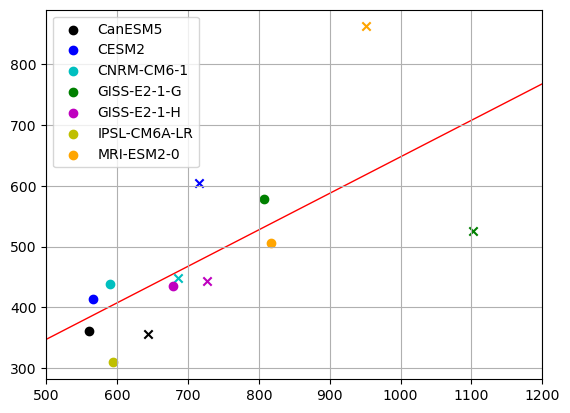

In [56]:
plt.figure()
density = 1030 # kg/m^3
c_p     = 4183 # J/K
seconds_per_year = 3.15e7 # s/y
colors = ['k', 'b', 'r', 'c', 'g', 'm', 'y', 'orange']
xs = []
ys = []

for i, model in enumerate(model_list):
    if model == 'MIROC6':
        continue
        
    elif model == 'IPSL-CM6A-LR': # IPSL-CM6A-LR is missing the abrupt-2xCO2 value
        plt.scatter(np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]), 
                    np.mean(heat_capacity_4x[model][-20:]*seconds_per_year/density/c_p), label=model, color=colors[i])
        
        xs.append(np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]))
        ys.append(np.mean(heat_capacity_4x[model][-20:]*seconds_per_year/density/c_p))

        
    else:
        plt.scatter(np.mean(heat_storage['abrupt-2xCO2'][model]['global']['55'][-20:]), 
                    np.mean(heat_capacity_2x[model][-20:]*seconds_per_year/density/c_p), marker='x', color=colors[i])
        
        xs.append(np.mean(heat_storage['abrupt-2xCO2'][model]['global']['55'][-20:]))
        ys.append(np.mean(heat_capacity_2x[model][-20:]*seconds_per_year/density/c_p))
        
        plt.scatter(np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]), 
                    np.mean(heat_capacity_4x[model][-20:]*seconds_per_year/density/c_p), label=model, color=colors[i])
        
        xs.append(np.mean(heat_storage['abrupt-4xCO2'][model]['global']['55'][-20:]))
        ys.append(np.mean(heat_capacity_4x[model][-20:]*seconds_per_year/density/c_p))

plt.legend()
plt.grid(zorder=-1)

slope, inte, r, p, std = stats.linregress(np.array(xs), np.array(ys))
print(slope, inte, r, p, std)

plt.plot(np.arange(500, 1200), np.arange(500, 1200)*slope + inte, color='r', zorder=0, linewidth=1)
plt.xlim(500, 1200)

# Script for Feedback Decomposition
### Need to download shortwave, longwave, clear sky fields to run

In [ ]:
## Table S5a CESM2 ##

fig1 = plt.figure(figsize=(15, 10))

for i, model in enumerate(['CESM2']):
    figx = figs[i]

    ## Pi ##   
    # cloudy sky
    rsut_pi = float(data3_pi[model][variable3][-100:, :].fillna(0).mean().values)
    rlut_pi = float(data4_pi[model][variable4][-100:, :].fillna(0).mean().values)
    
    # clear sky
    rsutcs_pi = float(data5_pi[model][variable5][-100, :].fillna(0).mean().values)
    rlutcs_pi = float(data6_pi[model][variable6][-100, :].fillna(0).mean().values)
    ##########
    
    ## 2x ##
    # tas and rtmt
    rtmt_2x = data1_2x[model][variable1  + '-gm'].resample(time='5Y').mean().values[0:30] - data1_pi[model]['pir'].values
    tas_2x  = data2_2x[model][variable2  + '-gm'].resample(time='5Y').mean().values[0:30] - data1_pi[model]['pit'].values
    
    # cloudy sky
    rsut_2x = data3_2x[model][variable3 + '-gm'].resample(time='5Y').mean().values[0:30] - rsut_pi
    rlut_2x = data4_2x[model][variable4 + '-gm'].resample(time='5Y').mean().values[0:30] - rlut_pi
    rsdt_2x = data11_2x[model][variable11 + '-gm'].resample(time='5Y').mean().values[0:30] - data1_pi[model]['pir'].values

    # clear sky
    rsutcs_2x = data5_2x[model][variable5 + '-gm'].resample(time='5Y').mean().values[0:30] - rsutcs_pi
    rlutcs_2x = data6_2x[model][variable6 + '-gm'].resample(time='5Y').mean().values[0:30] - rlutcs_pi
    ##########
    
    ## 4x ##
    # tas and rtmt
    rtmt_4x = data1_4x[model][variable1  + '-gm'].resample(time='5Y').mean().values[0:30] - data1_pi[model]['pir'].values
    tas_4x  = data2_4x[model][variable2  + '-gm'].resample(time='5Y').mean().values[0:30] - data1_pi[model]['pit'].values
    
    # cloudy sky
    rsut_4x = data3_4x[model][variable3 + '-gm'].resample(time='5Y').mean().values[0:30] - rsut_pi
    rlut_4x = data4_4x[model][variable4 + '-gm'].resample(time='5Y').mean().values[0:30] - rlut_pi
    rsdt_4x = data11_4x[model][variable11 + '-gm'].resample(time='5Y').mean().values[0:30] - data1_pi[model]['pir'].values
        
    # clear sky
    rsutcs_4x = data5_4x[model][variable5 + '-gm'].resample(time='5Y').mean().values[0:30] - rsutcs_pi
    rlutcs_4x = data6_4x[model][variable6 + '-gm'].resample(time='5Y').mean().values[0:30] - rlutcs_pi
    ##########
    
    ## Plots ##
    figx.suptitle(model)
    colorx = colors[i]
    
    # ax1, Traditional Gregory Plot (Cloudy total)
    ax1 = figx.add_subplot(2, 3, 1)
    ax1.plot(tas_4x, rtmt_4x, 'o', color='k')
    ax1.plot(tas_2x, rtmt_2x, 'o', color='r')
    ax1.set_title('Cloudy Total')
    ax1.set_ylabel('rtmt [w/m/m]')
    ax1.set_xlabel('tas [K]')
    ax1.legend(['Abrupt-4x', 'Abrupt-2x'])
    slope1, intercept, r, p, se = linregress(tas_4x[0:30], rtmt_4x[0:30])
    #slope2, intercept, r, p, se = linregress(tas_4x[5:30], rtmt_4x[5:30])
    slope3, intercept, r, p, se = linregress(tas_2x[0:30], rtmt_2x[0:30])
    #slope4, intercept, r, p, se = linregress(tas_2x[5:30], rtmt_2x[5:30])
    
    
    # ax2, Cloudy Shortwave
    ax2 = figx.add_subplot(2, 3, 2)        
    ax2.plot(tas_4x, rsut_4x - rsutcs_4x, 'o', color='k')
    ax2.plot(tas_2x, rsut_2x - rsutcs_2x, 'o', color='r')
    ax2.set_title('Cloudy SW')
    ax2.set_ylabel('rsut [w/m/m]')
    ax2.set_xlabel('tas [K]')
    slope5, intercept, r, p, se = linregress(tas_4x[0:30], rsut_4x[0:30] - rsutcs_4x[0:30])
    #slope6, intercept, r, p, se = linregress(tas_4x[5:30], rsut_4x[5:30] - rsutcs_4x[5:30])
    slope7, intercept, r, p, se = linregress(tas_2x[0:30], rsut_2x[0:30] - rsutcs_2x[0:30])
    #slope8, intercept, r, p, se = linregress(tas_2x[5:30], rsut_2x[5:30] - rsutcs_2x[5:30])
    
    
    # ax3, Cloudy Longwave
    ax3 = figx.add_subplot(2, 3, 3)        
    ax3.plot(tas_4x, rlut_4x - rlutcs_4x, 'o', color='k')
    ax3.plot(tas_2x, rlut_2x - rlutcs_2x, 'o', color='r')
    ax3.set_title('Cloud LW')
    ax3.set_ylabel('rlut [w/m/m]')
    ax3.set_xlabel('tas [K]')
    slope9, intercept, r, p, se = linregress(tas_4x[0:30], rlut_4x[0:30] - rlutcs_4x[0:30])
    #slope10, intercept, r, p, se = linregress(tas_4x[5:30], rlut_4x[5:30] - rlutcs_4x[5:30])
    slope11, intercept, r, p, se = linregress(tas_2x[0:30], rlut_2x[0:30] - rlutcs_2x[0:30])
    #slope12, intercept, r, p, se = linregress(tas_2x[5:30], rlut_2x[5:30] - rlutcs_2x[5:30])
    
    # ax4, Clear Sky Total
    ax4 = figx.add_subplot(2, 3, 4)
    ax4.plot(tas_4x, rsutcs_4x + rlutcs_4x, 'o', color='k')
    ax4.plot(tas_2x, rsutcs_2x + rlutcs_2x, 'o', color='r')
    ax4.set_title('Clear Sky Total')
    ax4.set_ylabel('rsutcs + rlutcs [w/m/m]')
    ax4.set_xlabel('tas [K]')
    slope13, intercept, r, p, se = linregress(tas_4x[0:30], rsutcs_4x[0:30] + rlutcs_4x[0:30])
    #slope14, intercept, r, p, se = linregress(tas_4x[5:30], rsutcs_4x[5:30] + rlutcs_4x[5:30])
    slope15, intercept, r, p, se = linregress(tas_2x[0:30], rsutcs_2x[0:30] + rlutcs_2x[0:30])
    #slope16, intercept, r, p, se = linregress(tas_2x[5:30], rsutcs_2x[5:30] + rlutcs_2x[5:30])
    
    # ax2, Clear Sky Shortwave
    ax5 = figx.add_subplot(2, 3, 5)        
    ax5.plot(tas_4x, rsutcs_4x, 'o', color='k')
    ax5.plot(tas_2x, rsutcs_2x, 'o', color='r')
    ax5.set_title('Clear Sky SW')
    ax5.set_ylabel('rsutcs [w/m/m]')
    ax5.set_xlabel('tas [K]')
    slope17, intercept, r, p, se = linregress(tas_4x[0:30], rsutcs_4x[0:30])
    #slope18, intercept, r, p, se = linregress(tas_4x[5:30], rsutcs_4x[5:30])
    slope19, intercept, r, p, se = linregress(tas_2x[0:30], rsutcs_2x[0:30])
    #slope20, intercept, r, p, se = linregress(tas_2x[5:30], rsutcs_2x[5:30])
    
    # ax3, Clear Sky Longwave
    ax6 = figx.add_subplot(2, 3, 6)        
    ax6.plot(tas_4x, rlutcs_4x, 'o', color='k')
    ax6.plot(tas_2x, rlutcs_2x, 'o', color='r')
    ax6.set_title('Clear Sky LW')
    ax6.set_ylabel('rlutcs [w/m/m]')
    ax6.set_xlabel('tas [K]')
    slope21, intercept, r, p, se = linregress(tas_4x[0:30], rlutcs_4x[0:30])
    #slope22, intercept, r, p, se = linregress(tas_4x[5:30], rlutcs_4x[5:30])
    slope23, intercept, r, p, se = linregress(tas_2x[0:30], rlutcs_2x[0:30])
    #slope24, intercept, r, p, se = linregress(tas_2x[5:30], rlutcs_2x[5:30])

    
    print('\n Net 4x', slope1, '\n Net 2x', slope3, '\n SW Cloud 4x', slope5, '\n SW Cloud 2x', slope7)
    print('\n LW Cloud 4x', slope9, '\n LW Cloud 2x', slope11, '\n  SW Clear 4x', slope17, '\n SW Clear 2x', slope19)
    print('\n LW Clear 4x', slope21, '\n LW Clear 2x', slope23)
    

In [ ]:
## Table S5b MRI-ESM2-0 ##

fig1 = plt.figure(figsize=(15, 10))

for i, model in enumerate(['MRI-ESM2-0']):
    figx = figs[i]

    ## Pi ##   
    # cloudy sky
    rsut_pi = float(data3_pi[model][variable3][-100:, :].fillna(0).mean().values)
    rlut_pi = float(data4_pi[model][variable4][-100:, :].fillna(0).mean().values)
    
    # clear sky
    rsutcs_pi = float(data5_pi[model][variable5][-100, :].fillna(0).mean().values)
    rlutcs_pi = float(data6_pi[model][variable6][-100, :].fillna(0).mean().values)
    ##########
    
    ## 2x ##
    # tas and rtmt
    #rtmt_2x = data1_2x[model][variable1  + '-gm'].resample(time='5Y').mean().values[0:30] - data1_pi[model]['pir'].values
    tas_2x  = data2_2x[model][variable2  + '-gm'].resample(time='5Y').mean().values[0:30] - data2_pi[model]['pit'].values
    
    # cloudy sky
    rsut_2x = data3_2x[model][variable3 + '-gm'].resample(time='5Y').mean().values[0:30] - rsut_pi
    rlut_2x = data4_2x[model][variable4 + '-gm'].resample(time='5Y').mean().values[0:30] - rlut_pi
    rsdt_2x = data11_2x[model][variable11 + '-gm'].resample(time='5Y').mean().values[0:30] - data2_pi[model]['pir'].values

    # clear sky
    rsutcs_2x = data5_2x[model][variable5 + '-gm'].resample(time='5Y').mean().values[0:30] - rsutcs_pi
    rlutcs_2x = data6_2x[model][variable6 + '-gm'].resample(time='5Y').mean().values[0:30] - rlutcs_pi
    ##########
    
    ## 4x ##
    # tas and rtmt
    #rtmt_4x = data1_4x[model][variable1  + '-gm'].resample(time='5Y').mean().values[0:30] - data1_pi[model]['pir'].values
    tas_4x  = data2_4x[model][variable2  + '-gm'].resample(time='5Y').mean().values[0:30] - data2_pi[model]['pit'].values
    
    # cloudy sky
    rsut_4x = data3_4x[model][variable3 + '-gm'].resample(time='5Y').mean().values[0:30] - rsut_pi
    rlut_4x = data4_4x[model][variable4 + '-gm'].resample(time='5Y').mean().values[0:30] - rlut_pi
    rsdt_4x = data11_4x[model][variable11 + '-gm'].resample(time='5Y').mean().values[0:30] - data2_pi[model]['pir'].values
        
    # clear sky
    rsutcs_4x = data5_4x[model][variable5 + '-gm'].resample(time='5Y').mean().values[0:30] - rsutcs_pi
    rlutcs_4x = data6_4x[model][variable6 + '-gm'].resample(time='5Y').mean().values[0:30] - rlutcs_pi
    ##########
    
    ## Plots ##
    figx.suptitle(model)
    colorx = colors[i]
    
    # ax1, Traditional Gregory Plot (Cloudy total)
    ax1 = figx.add_subplot(2, 3, 1)
    #ax1.plot(tas_4x, rtmt_4x, 'o', color='k')
    #ax1.plot(tas_2x, rtmt_2x, 'o', color='r')
    ax1.set_title('Cloudy Total')
    ax1.set_ylabel('rtmt [w/m/m]')
    ax1.set_xlabel('tas [K]')
    ax1.legend(['Abrupt-4x', 'Abrupt-2x'])
    slope1, intercept, r, p, se = linregress(tas_4x[0:30], rsut_4x[0:30] - rsutcs_4x[0:30] + rlut_4x[0:30] - rlutcs_4x[0:30])
    #slope2, intercept, r, p, se = linregress(tas_4x[5:30], rtmt_4x[5:30])
    slope3, intercept, r, p, se = linregress(tas_2x[0:30], rsut_2x[0:30] - rsutcs_2x[0:30] + rlut_2x[0:30] - rlutcs_2x[0:30])
    #slope4, intercept, r, p, se = linregress(tas_2x[5:30], rtmt_2x[5:30])
    
    
    # ax2, Cloudy Shortwave
    ax2 = figx.add_subplot(2, 3, 2)        
    ax2.plot(tas_4x, rsut_4x - rsutcs_4x, 'o', color='k')
    ax2.plot(tas_2x, rsut_2x - rsutcs_2x, 'o', color='r')
    ax2.set_title('Cloudy SW')
    ax2.set_ylabel('rsut [w/m/m]')
    ax2.set_xlabel('tas [K]')
    slope5, intercept, r, p, se = linregress(tas_4x[0:30], rsut_4x[0:30] - rsutcs_4x[0:30])
    #slope6, intercept, r, p, se = linregress(tas_4x[5:30], rsut_4x[5:30] - rsutcs_4x[5:30])
    slope7, intercept, r, p, se = linregress(tas_2x[0:30], rsut_2x[0:30] - rsutcs_2x[0:30])
    #slope8, intercept, r, p, se = linregress(tas_2x[5:30], rsut_2x[5:30] - rsutcs_2x[5:30])
    
    
    # ax3, Cloudy Longwave
    ax3 = figx.add_subplot(2, 3, 3)        
    ax3.plot(tas_4x, rlut_4x - rlutcs_4x, 'o', color='k')
    ax3.plot(tas_2x, rlut_2x - rlutcs_2x, 'o', color='r')
    ax3.set_title('Cloud LW')
    ax3.set_ylabel('rlut [w/m/m]')
    ax3.set_xlabel('tas [K]')
    slope9, intercept, r, p, se = linregress(tas_4x[0:30], rlut_4x[0:30] - rlutcs_4x[0:30])
    #slope10, intercept, r, p, se = linregress(tas_4x[5:30], rlut_4x[5:30] - rlutcs_4x[5:30])
    slope11, intercept, r, p, se = linregress(tas_2x[0:30], rlut_2x[0:30] - rlutcs_2x[0:30])
    #slope12, intercept, r, p, se = linregress(tas_2x[5:30], rlut_2x[5:30] - rlutcs_2x[5:30])
    
    # ax4, Clear Sky Total
    ax4 = figx.add_subplot(2, 3, 4)
    ax4.plot(tas_4x, rsutcs_4x + rlutcs_4x, 'o', color='k')
    ax4.plot(tas_2x, rsutcs_2x + rlutcs_2x, 'o', color='r')
    ax4.set_title('Clear Sky Total')
    ax4.set_ylabel('rsutcs + rlutcs [w/m/m]')
    ax4.set_xlabel('tas [K]')
    slope13, intercept, r, p, se = linregress(tas_4x[0:30], rsutcs_4x[0:30] + rlutcs_4x[0:30])
    #slope14, intercept, r, p, se = linregress(tas_4x[5:30], rsutcs_4x[5:30] + rlutcs_4x[5:30])
    slope15, intercept, r, p, se = linregress(tas_2x[0:30], rsutcs_2x[0:30] + rlutcs_2x[0:30])
    #slope16, intercept, r, p, se = linregress(tas_2x[5:30], rsutcs_2x[5:30] + rlutcs_2x[5:30])
    
    # ax2, Clear Sky Shortwave
    ax5 = figx.add_subplot(2, 3, 5)        
    ax5.plot(tas_4x, rsutcs_4x, 'o', color='k')
    ax5.plot(tas_2x, rsutcs_2x, 'o', color='r')
    ax5.set_title('Clear Sky SW')
    ax5.set_ylabel('rsutcs [w/m/m]')
    ax5.set_xlabel('tas [K]')
    slope17, intercept, r, p, se = linregress(tas_4x[0:30], rsutcs_4x[0:30])
    #slope18, intercept, r, p, se = linregress(tas_4x[5:30], rsutcs_4x[5:30])
    slope19, intercept, r, p, se = linregress(tas_2x[0:30], rsutcs_2x[0:30])
    #slope20, intercept, r, p, se = linregress(tas_2x[5:30], rsutcs_2x[5:30])
    
    # ax3, Clear Sky Longwave
    ax6 = figx.add_subplot(2, 3, 6)        
    ax6.plot(tas_4x, rlutcs_4x, 'o', color='k')
    ax6.plot(tas_2x, rlutcs_2x, 'o', color='r')
    ax6.set_title('Clear Sky LW')
    ax6.set_ylabel('rlutcs [w/m/m]')
    ax6.set_xlabel('tas [K]')
    slope21, intercept, r, p, se = linregress(tas_4x[0:30], rlutcs_4x[0:30])
    #slope22, intercept, r, p, se = linregress(tas_4x[5:30], rlutcs_4x[5:30])
    slope23, intercept, r, p, se = linregress(tas_2x[0:30], rlutcs_2x[0:30])
    #slope24, intercept, r, p, se = linregress(tas_2x[5:30], rlutcs_2x[5:30])

    
    #print('\n Net 4x', slope1, '\n Net 2x', slope3, 
    print('\n SW Cloud 4x', slope5, '\n SW Cloud 2x', slope7, '\n net Cloud 4x', slope1, '\n net Clear 2x', slope3)
    print('\n LW Cloud 4x', slope9, '\n LW Cloud 2x', slope11, '\n  SW Clear 4x', slope17, '\n SW Clear 2x', slope19)
    print('\n LW Clear 4x', slope21, '\n LW Clear 2x', slope23)